In [1]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

from keras.optimizers import SGD
from keras.models import load_model
from keras.models import save_model

from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
from six import StringIO
import collections
from copy import copy

import mhcnames

from mhcnames import normalize_allele_name

import sklearn
import scipy


from sklearn.metrics import f1_score, accuracy_score

from sklearn.model_selection import train_test_split

In [31]:
import mhcflurry
from mhcflurry import Class1AffinityPredictor, Class1NeuralNetwork, scoring, select_allele_specific_models_command
from mhcflurry.downloads import get_path
from mhcflurry.amino_acid import index_encoding, fixed_vectors_encoding, available_vector_encodings, vector_encoding_length, COMMON_AMINO_ACIDS, ENCODING_DATA_FRAMES, AMINO_ACID_INDEX, BLOSUM62_MATRIX
from mhcflurry import encodable_sequences

In [5]:
#get data path
data_path = get_path("data_curated", "curated_training_data.no_mass_spec.csv.bz2")

#read training data
df = pd.read_csv(data_path)

df.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
0,BoLA-1*21:01,AENDTLVVSV,7817.0,=,quantitative,Barlow - purified MHC/competitive/fluorescence,BoLA-1*02101
1,BoLA-1*21:01,NQFNGGCLLV,1086.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-1*02101
2,BoLA-2*08:01,AAHCIHAEW,21.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
3,BoLA-2*08:01,AAKHMSNTY,1299.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
4,BoLA-2*08:01,DSYAYMRNGW,2.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801


In [6]:
#only select peptide between 8 to 15
df = df.loc[(df.peptide.str.len() >= 8) & (df.peptide.str.len() <= 15)]

df.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
0,BoLA-1*21:01,AENDTLVVSV,7817.0,=,quantitative,Barlow - purified MHC/competitive/fluorescence,BoLA-1*02101
1,BoLA-1*21:01,NQFNGGCLLV,1086.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-1*02101
2,BoLA-2*08:01,AAHCIHAEW,21.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
3,BoLA-2*08:01,AAKHMSNTY,1299.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801
4,BoLA-2*08:01,DSYAYMRNGW,2.0,=,quantitative,Barlow - purified MHC/direct/fluorescence,BoLA-2*00801


In [18]:
hla_index = ["HLA-A*01:01","HLA-A*02:01","HLA-A*02:03","HLA-A*02:07","HLA-A*03:01","HLA-A*24:02","HLA-A*29:02","HLA-A*31:01","HLA-A*68:02","HLA-B*35:01","HLA-B*44:02","HLA-B*44:03","HLA-B*51:01","HLA-B*54:01","HLA-B*57:01"]

HLA = df[df['allele'].isin(hla_index)]

HLA.head()

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
15879,HLA-A*01:01,AADFPGIAR,20000.0,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01
15880,HLA-A*01:01,AADKAAAAAY,45.0,=,quantitative,Michel - purified MHC/competitive/radioactivity,HLA-A*01:01
15881,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01
15882,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01
15883,HLA-A*01:01,AADSFATSY,1000.0,<,qualitative,Ph.D. - purified MHC/direct/radioactivity,HLA-A*01:01


In [19]:
HLA.loc[:,'peptide_length'] = (HLA.peptide.str.len())

HLA.groupby(['peptide_length']).count()

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele
peptide_length,,,,,,,
8,1325,1325,1325,1325,1325,1325,1325
9,62919,62919,62919,62919,62919,62919,62919
10,18779,18779,18779,18779,18779,18779,18779
11,1569,1569,1569,1569,1569,1569,1569
12,159,159,159,159,159,159,159
13,172,172,172,172,172,172,172
14,167,167,167,167,167,167,167
15,328,328,328,328,328,328,328


In [20]:
#predict classes

HLA["class"] = False

HLA.loc[HLA['measurement_value'] <=1, 'class'] = 'high'
HLA.loc[(HLA['measurement_value'] <=100) & (HLA['measurement_value'] >1), 'class'] = 'medium'
HLA.loc[(HLA['measurement_value'] <=10000) & (HLA['measurement_value'] >100), 'class'] = 'low'
HLA.loc[HLA['measurement_value'] >=10000, 'class'] = 'non'

HLA.groupby(["class"]).count()

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length
class,,,,,,,,
high,1638,1638,1638,1638,1638,1638,1638,1638
low,36947,36947,36947,36947,36947,36947,36947,36947
medium,13452,13452,13452,13452,13452,13452,13452,13452
non,33381,33381,33381,33381,33381,33381,33381,33381


In [21]:
HLA["class_code"] = HLA["class"].astype('category').cat.codes

HLA.head()

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length,class,class_code
15879,HLA-A*01:01,AADFPGIAR,20000.0,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,9,non,3
15880,HLA-A*01:01,AADKAAAAAY,45.0,=,quantitative,Michel - purified MHC/competitive/radioactivity,HLA-A*01:01,10,medium,2
15881,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01,9,medium,2
15882,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,9,medium,2
15883,HLA-A*01:01,AADSFATSY,1000.0,<,qualitative,Ph.D. - purified MHC/direct/radioactivity,HLA-A*01:01,9,low,1


In [22]:
HLA.groupby(["allele"]).count()

,peptide,measurement_value,measurement_inequality,measurement_type,measurement_source,original_allele,peptide_length,class,class_code
allele,,,,,,,,,
HLA-A*01:01,6153,6153,6153,6153,6153,6153,6153,6153,6153
HLA-A*02:01,24629,24629,24629,24629,24629,24629,24629,24629,24629
HLA-A*02:03,7846,7846,7846,7846,7846,7846,7846,7846,7846
HLA-A*02:07,126,126,126,126,126,126,126,126,126
HLA-A*03:01,9574,9574,9574,9574,9574,9574,9574,9574,9574
HLA-A*24:02,5814,5814,5814,5814,5814,5814,5814,5814,5814
HLA-A*29:02,2741,2741,2741,2741,2741,2741,2741,2741,2741
HLA-A*31:01,6260,6260,6260,6260,6260,6260,6260,6260,6260
HLA-A*68:02,7223,7223,7223,7223,7223,7223,7223,7223,7223


In [24]:
def get_train_test (HLA, allele, test_frac):
    #get desired allele data
    allele_oi = HLA[HLA.allele == allele]
    
    #distribute between train and test sets
    np.random.seed(4060)
    test_samples = allele_oi.reset_index().groupby('peptide_length')["index"].apply(lambda x: x.sample(frac=test_frac))
    
    allele_oi.loc[:,"subset"] = "train"
    allele_oi.loc[test_samples, "subset"] = "test"

    #extract train and test sets
    train = allele_oi[allele_oi["subset"] == "train"]

    test = allele_oi[allele_oi["subset"] == "test"]

    #assign 
    X_train_pre = np.array(train["peptide"])
    y_train_pre = np.array(train["class_code"])
    X_test_pre = np.array(test["peptide"])
    y_test_pre = np.array(test["class_code"])
    
    return X_train_pre, y_train_pre, X_test_pre, y_test_pre

In [25]:
def encode_flatten (X_train_pre, X_test_pre):
    #encode peptide to fixed length and index
    X_train = encodable_sequences.EncodableSequences.sequences_to_fixed_length_index_encoded_array(X_train_pre)
    X_test = encodable_sequences.EncodableSequences.sequences_to_fixed_length_index_encoded_array(X_test_pre)
    
    #fixed vector encoding to BLOSUM62
    X_train_ = fixed_vectors_encoding(X_train, BLOSUM62_MATRIX) 
    X_test_ = fixed_vectors_encoding(X_test, BLOSUM62_MATRIX) 
    
    #flatten
        
    input_shape = 315
    n_class = 4

    X_train_ = np.reshape(X_train_, (X_train_.shape[0], input_shape))

    X_test_ = np.reshape(X_test_, (X_test_.shape[0], input_shape))
    
    return X_train_, X_test_

In [26]:
def y_categorical (y_train_pre, y_test_pre, n_class):
    #one hot encode categories
    y_train = to_categorical(y_train_pre, num_classes=n_class, dtype='float32')
    y_test = to_categorical(y_test_pre, num_classes=n_class, dtype='float32')
    
    return y_train, y_test


In [27]:
def plot_history(history, allele):
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    #plt.plot(history.history["loss"], label="train_loss")
    #plt.plot(history.history["val_loss"], label="val_loss")
    plt.plot(history.history["acc"], label="train_acc")
    plt.plot(history.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy for allele = {}".format(allele))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")

In [28]:
def model_fit_allele(allele, data, test_frac, n_class, model, epochs, results):
    allele = allele

    #set data and encode
    X_train_pre, y_train_pre, X_test_pre, y_test_pre = get_train_test (HLA = HLA, allele = allele, test_frac=test_frac)

    X_train_, X_test_ = encode_flatten (X_train_pre, X_test_pre)

    y_train, y_test = y_categorical (y_train_pre, y_test_pre, n_class=n_class)
    
    #set location to save weights
    name = normalize_allele_name(allele)
    file_path = ('%s_best_weight.h5' %name)
    checkpoint = ModelCheckpoint(file_path, 
                                 monitor='val_acc', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto', 
                                 period=1 
                                )
    #fit model
    history = model.fit(
        X_train_,
        y_train,
        epochs=epochs,
        batch_size=80,
        validation_split=0.1,
        verbose=1,
        callbacks=[checkpoint]
    )
    


    metrics = model.evaluate(X_test_, y_test)
    y_pred = model.predict_classes(X_test_)
    pearson = scipy.stats.pearsonr(y_test_pre, y_pred)
    f1 = f1_score(y_test_pre, y_pred, average = 'weighted')
    results = results.append({"allele": allele, "val_acc":metrics[1], "f1_score":f1, "pearson_r":pearson[0]}, ignore_index=True)
    
    plot_history(history, allele)
    
    return history, metrics, results
    

In [29]:
#construct keras model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D

# import regularizer
from keras.regularizers import l1, l2

input_shape = 315

model = Sequential()
model.add(Dense(315, activation='tanh', activity_regularizer=l2(0.0001), input_dim=input_shape))
model.add(Dropout(0.4))
model.add(Dense(150, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(75, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
             )


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 315)               99540     
_________________________________________________________________
dropout_1 (Dropout)          (None, 315)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               47400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 75)                11325     
_________________________________________________________________
dropout_3 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 304       
Total para

Train on 4984 samples, validate on 554 samples
Epoch 1/100
4984/4984 [==============================] - ETA: 15s - loss: 3.3121 - acc: 0.17 - ETA: 0s - loss: 2.4977 - acc: 0.5028 - ETA: 0s - loss: 2.3924 - acc: 0.528 - ETA: 0s - loss: 2.3256 - acc: 0.543 - 0s 92us/step - loss: 2.2996 - acc: 0.5433 - val_loss: 2.1676 - val_acc: 0.5848

Epoch 00001: val_acc improved from -inf to 0.58484, saving model to HLA-A_01_01_best_weight.h5
Epoch 2/100
4984/4984 [==============================] - ETA: 0s - loss: 2.1675 - acc: 0.562 - ETA: 0s - loss: 2.0869 - acc: 0.568 - ETA: 0s - loss: 2.0413 - acc: 0.579 - ETA: 0s - loss: 2.0154 - acc: 0.581 - 0s 36us/step - loss: 2.0051 - acc: 0.5833 - val_loss: 1.9624 - val_acc: 0.5812

Epoch 00002: val_acc did not improve from 0.58484
Epoch 3/100
4984/4984 [==============================] - ETA: 0s - loss: 1.7933 - acc: 0.750 - ETA: 0s - loss: 1.8568 - acc: 0.611 - ETA: 0s - loss: 1.8401 - acc: 0.596 - 0s 32us/step - loss: 1.8150 - acc: 0.5967 - val_loss: 1.86

Epoch 00026: val_acc did not improve from 0.61913
Epoch 27/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8899 - acc: 0.662 - ETA: 0s - loss: 0.8905 - acc: 0.638 - ETA: 0s - loss: 0.8915 - acc: 0.641 - 0s 29us/step - loss: 0.8890 - acc: 0.6449 - val_loss: 1.1703 - val_acc: 0.5812

Epoch 00027: val_acc did not improve from 0.61913
Epoch 28/100
4984/4984 [==============================] - ETA: 0s - loss: 1.0241 - acc: 0.575 - ETA: 0s - loss: 0.8855 - acc: 0.643 - ETA: 0s - loss: 0.8798 - acc: 0.652 - 0s 29us/step - loss: 0.8751 - acc: 0.6539 - val_loss: 1.0723 - val_acc: 0.6119

Epoch 00028: val_acc did not improve from 0.61913
Epoch 29/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8130 - acc: 0.675 - ETA: 0s - loss: 0.8770 - acc: 0.659 - ETA: 0s - loss: 0.8838 - acc: 0.649 - 0s 29us/step - loss: 0.8857 - acc: 0.6475 - val_loss: 1.1714 - val_acc: 0.5560

Epoch 00029: val_acc did not improve from 0.61913
Epoch 30/100
4984/4984 [====================

4984/4984 [==============================] - ETA: 0s - loss: 0.8169 - acc: 0.625 - ETA: 0s - loss: 0.8288 - acc: 0.652 - ETA: 0s - loss: 0.8250 - acc: 0.654 - 0s 29us/step - loss: 0.8247 - acc: 0.6513 - val_loss: 1.0341 - val_acc: 0.5884

Epoch 00053: val_acc did not improve from 0.62094
Epoch 54/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8116 - acc: 0.700 - ETA: 0s - loss: 0.8234 - acc: 0.661 - ETA: 0s - loss: 0.8194 - acc: 0.660 - 0s 29us/step - loss: 0.8215 - acc: 0.6561 - val_loss: 1.0908 - val_acc: 0.5668

Epoch 00054: val_acc did not improve from 0.62094
Epoch 55/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8531 - acc: 0.625 - ETA: 0s - loss: 0.8137 - acc: 0.663 - ETA: 0s - loss: 0.8175 - acc: 0.663 - 0s 30us/step - loss: 0.8209 - acc: 0.6621 - val_loss: 1.0283 - val_acc: 0.5939

Epoch 00055: val_acc did not improve from 0.62094
Epoch 56/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8401 - acc: 0.650 - ETA: 0s - l

Epoch 80/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8103 - acc: 0.700 - ETA: 0s - loss: 0.8133 - acc: 0.650 - ETA: 0s - loss: 0.8094 - acc: 0.658 - 0s 31us/step - loss: 0.8072 - acc: 0.6595 - val_loss: 1.0603 - val_acc: 0.6101

Epoch 00080: val_acc did not improve from 0.62094
Epoch 81/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8192 - acc: 0.650 - ETA: 0s - loss: 0.7763 - acc: 0.680 - ETA: 0s - loss: 0.7788 - acc: 0.677 - 0s 29us/step - loss: 0.7931 - acc: 0.6738 - val_loss: 1.0748 - val_acc: 0.6173

Epoch 00081: val_acc did not improve from 0.62094
Epoch 82/100
4984/4984 [==============================] - ETA: 0s - loss: 0.7282 - acc: 0.775 - ETA: 0s - loss: 0.8105 - acc: 0.663 - ETA: 0s - loss: 0.8013 - acc: 0.668 - 0s 30us/step - loss: 0.8061 - acc: 0.6625 - val_loss: 1.0435 - val_acc: 0.6137

Epoch 00082: val_acc did not improve from 0.62094
Epoch 83/100
4984/4984 [==============================] - ETA: 0s - loss: 0.8302 - acc: 0.637 

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

Train on 19948 samples, validate on 2217 samples
Epoch 1/100
19948/19948 [==============================] - ETA: 1s - loss: 1.9927 - acc: 0.337 - ETA: 0s - loss: 1.4576 - acc: 0.476 - ETA: 0s - loss: 1.3200 - acc: 0.498 - ETA: 0s - loss: 1.2587 - acc: 0.512 - ETA: 0s - loss: 1.2168 - acc: 0.525 - ETA: 0s - loss: 1.1890 - acc: 0.531 - ETA: 0s - loss: 1.1610 - acc: 0.537 - ETA: 0s - loss: 1.1513 - acc: 0.539 - ETA: 0s - loss: 1.1398 - acc: 0.541 - ETA: 0s - loss: 1.1284 - acc: 0.544 - ETA: 0s - loss: 1.1218 - acc: 0.545 - ETA: 0s - loss: 1.1147 - acc: 0.547 - ETA: 0s - loss: 1.1044 - acc: 0.550 - ETA: 0s - loss: 1.0968 - acc: 0.553 - ETA: 0s - loss: 1.0895 - acc: 0.554 - 1s 38us/step - loss: 1.0890 - acc: 0.5545 - val_loss: 1.2574 - val_acc: 0.5462

Epoch 00001: val_acc improved from -inf to 0.54623, saving model to HLA-A_02_01_best_weight.h5
Epoch 2/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0591 - acc: 0.500 - ETA: 0s - loss: 0.9852 - acc: 0.590 - ETA: 0s - lo

19948/19948 [==============================] - ETA: 0s - loss: 0.9821 - acc: 0.550 - ETA: 0s - loss: 0.8886 - acc: 0.616 - ETA: 0s - loss: 0.9041 - acc: 0.604 - ETA: 0s - loss: 0.9110 - acc: 0.605 - ETA: 0s - loss: 0.9189 - acc: 0.599 - ETA: 0s - loss: 0.9148 - acc: 0.598 - ETA: 0s - loss: 0.9165 - acc: 0.599 - ETA: 0s - loss: 0.9140 - acc: 0.600 - ETA: 0s - loss: 0.9190 - acc: 0.596 - ETA: 0s - loss: 0.9197 - acc: 0.596 - ETA: 0s - loss: 0.9208 - acc: 0.597 - ETA: 0s - loss: 0.9207 - acc: 0.597 - ETA: 0s - loss: 0.9226 - acc: 0.597 - 1s 33us/step - loss: 0.9220 - acc: 0.5973 - val_loss: 1.1647 - val_acc: 0.5737

Epoch 00012: val_acc did not improve from 0.57826
Epoch 13/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0517 - acc: 0.575 - ETA: 0s - loss: 0.9149 - acc: 0.598 - ETA: 0s - loss: 0.9075 - acc: 0.607 - ETA: 0s - loss: 0.9184 - acc: 0.599 - ETA: 0s - loss: 0.9192 - acc: 0.602 - ETA: 0s - loss: 0.9170 - acc: 0.600 - ETA: 0s - loss: 0.9160 - acc: 0.601 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.9244 - acc: 0.575 - ETA: 0s - loss: 0.8824 - acc: 0.627 - ETA: 0s - loss: 0.8908 - acc: 0.627 - ETA: 0s - loss: 0.9079 - acc: 0.619 - ETA: 0s - loss: 0.9071 - acc: 0.619 - ETA: 0s - loss: 0.9064 - acc: 0.619 - ETA: 0s - loss: 0.9088 - acc: 0.618 - ETA: 0s - loss: 0.9079 - acc: 0.617 - ETA: 0s - loss: 0.9091 - acc: 0.614 - ETA: 0s - loss: 0.9119 - acc: 0.612 - ETA: 0s - loss: 0.9131 - acc: 0.611 - ETA: 0s - loss: 0.9122 - acc: 0.609 - 1s 31us/step - loss: 0.9107 - acc: 0.6099 - val_loss: 1.1560 - val_acc: 0.5489

Epoch 00024: val_acc did not improve from 0.57826
Epoch 25/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9912 - acc: 0.625 - ETA: 0s - loss: 0.9189 - acc: 0.634 - ETA: 0s - loss: 0.9093 - acc: 0.620 - ETA: 0s - loss: 0.9064 - acc: 0.626 - ETA: 0s - loss: 0.9186 - acc: 0.615 - ETA: 0s - loss: 0.9176 - acc: 0.608 - ETA: 0s - loss: 0.9182 - acc: 0.608 - ETA: 0s - loss: 0.9156 - acc: 0.609 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.9019 - acc: 0.662 - ETA: 0s - loss: 0.8881 - acc: 0.614 - ETA: 0s - loss: 0.8983 - acc: 0.623 - ETA: 0s - loss: 0.9029 - acc: 0.621 - ETA: 0s - loss: 0.9065 - acc: 0.615 - ETA: 0s - loss: 0.9079 - acc: 0.612 - ETA: 0s - loss: 0.9042 - acc: 0.611 - ETA: 0s - loss: 0.9058 - acc: 0.610 - ETA: 0s - loss: 0.9042 - acc: 0.612 - ETA: 0s - loss: 0.9050 - acc: 0.612 - ETA: 0s - loss: 0.9035 - acc: 0.611 - ETA: 0s - loss: 0.9043 - acc: 0.610 - 1s 31us/step - loss: 0.9062 - acc: 0.6095 - val_loss: 1.1216 - val_acc: 0.5765

Epoch 00036: val_acc did not improve from 0.57916
Epoch 37/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9562 - acc: 0.625 - ETA: 0s - loss: 0.9279 - acc: 0.597 - ETA: 0s - loss: 0.9138 - acc: 0.606 - ETA: 0s - loss: 0.9068 - acc: 0.605 - ETA: 0s - loss: 0.9056 - acc: 0.607 - ETA: 0s - loss: 0.9064 - acc: 0.607 - ETA: 0s - loss: 0.9031 - acc: 0.608 - ETA: 0s - loss: 0.8998 - acc: 0.611 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.9625 - acc: 0.550 - ETA: 0s - loss: 0.8751 - acc: 0.621 - ETA: 0s - loss: 0.8908 - acc: 0.624 - ETA: 0s - loss: 0.8975 - acc: 0.624 - ETA: 0s - loss: 0.8923 - acc: 0.629 - ETA: 0s - loss: 0.8991 - acc: 0.627 - ETA: 0s - loss: 0.8985 - acc: 0.624 - ETA: 0s - loss: 0.9005 - acc: 0.622 - ETA: 0s - loss: 0.8977 - acc: 0.624 - ETA: 0s - loss: 0.8994 - acc: 0.624 - ETA: 0s - loss: 0.9050 - acc: 0.620 - ETA: 0s - loss: 0.9051 - acc: 0.621 - ETA: 0s - loss: 0.9018 - acc: 0.620 - 1s 32us/step - loss: 0.9022 - acc: 0.6207 - val_loss: 1.1760 - val_acc: 0.5544

Epoch 00048: val_acc did not improve from 0.57916
Epoch 49/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0035 - acc: 0.587 - ETA: 0s - loss: 0.9169 - acc: 0.614 - ETA: 0s - loss: 0.9042 - acc: 0.625 - ETA: 0s - loss: 0.8973 - acc: 0.633 - ETA: 0s - loss: 0.8978 - acc: 0.630 - ETA: 0s - loss: 0.9000 - acc: 0.625 - ETA: 0s - loss: 0.8994 - acc: 0.626 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 1.0720 - acc: 0.587 - ETA: 0s - loss: 0.9073 - acc: 0.616 - ETA: 0s - loss: 0.9009 - acc: 0.617 - ETA: 0s - loss: 0.8963 - acc: 0.621 - ETA: 0s - loss: 0.8977 - acc: 0.623 - ETA: 0s - loss: 0.8983 - acc: 0.625 - ETA: 0s - loss: 0.9036 - acc: 0.619 - ETA: 0s - loss: 0.9057 - acc: 0.617 - ETA: 0s - loss: 0.9076 - acc: 0.614 - ETA: 0s - loss: 0.9047 - acc: 0.615 - ETA: 0s - loss: 0.9042 - acc: 0.616 - ETA: 0s - loss: 0.9023 - acc: 0.616 - 1s 32us/step - loss: 0.9022 - acc: 0.6171 - val_loss: 1.2296 - val_acc: 0.5435

Epoch 00060: val_acc did not improve from 0.57916
Epoch 61/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0419 - acc: 0.562 - ETA: 0s - loss: 0.9069 - acc: 0.619 - ETA: 0s - loss: 0.8990 - acc: 0.619 - ETA: 0s - loss: 0.9086 - acc: 0.616 - ETA: 0s - loss: 0.9076 - acc: 0.614 - ETA: 0s - loss: 0.9098 - acc: 0.611 - ETA: 0s - loss: 0.9086 - acc: 0.612 - ETA: 0s - loss: 0.9054 - acc: 0.613 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.8975 - acc: 0.662 - ETA: 0s - loss: 0.8944 - acc: 0.625 - ETA: 0s - loss: 0.8981 - acc: 0.629 - ETA: 0s - loss: 0.8957 - acc: 0.628 - ETA: 0s - loss: 0.9063 - acc: 0.622 - ETA: 0s - loss: 0.9075 - acc: 0.621 - ETA: 0s - loss: 0.9108 - acc: 0.617 - ETA: 0s - loss: 0.9114 - acc: 0.616 - ETA: 0s - loss: 0.9093 - acc: 0.616 - ETA: 0s - loss: 0.9088 - acc: 0.618 - ETA: 0s - loss: 0.9058 - acc: 0.619 - ETA: 0s - loss: 0.9065 - acc: 0.618 - 1s 31us/step - loss: 0.9048 - acc: 0.6194 - val_loss: 1.1956 - val_acc: 0.5571

Epoch 00072: val_acc did not improve from 0.57916
Epoch 73/100
19948/19948 [==============================] - ETA: 0s - loss: 1.0116 - acc: 0.550 - ETA: 0s - loss: 0.8841 - acc: 0.627 - ETA: 0s - loss: 0.8956 - acc: 0.625 - ETA: 0s - loss: 0.9026 - acc: 0.620 - ETA: 0s - loss: 0.9013 - acc: 0.622 - ETA: 0s - loss: 0.8976 - acc: 0.625 - ETA: 0s - loss: 0.9008 - acc: 0.619 - ETA: 0s - loss: 0.8981 - acc: 0.623 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 0.9862 - acc: 0.625 - ETA: 0s - loss: 0.8940 - acc: 0.622 - ETA: 0s - loss: 0.9160 - acc: 0.611 - ETA: 0s - loss: 0.9068 - acc: 0.616 - ETA: 0s - loss: 0.9100 - acc: 0.615 - ETA: 0s - loss: 0.9096 - acc: 0.616 - ETA: 0s - loss: 0.9053 - acc: 0.619 - ETA: 0s - loss: 0.9089 - acc: 0.619 - ETA: 0s - loss: 0.9105 - acc: 0.619 - ETA: 0s - loss: 0.9099 - acc: 0.620 - ETA: 0s - loss: 0.9057 - acc: 0.621 - ETA: 0s - loss: 0.9076 - acc: 0.621 - 1s 32us/step - loss: 0.9058 - acc: 0.6216 - val_loss: 1.2658 - val_acc: 0.5368

Epoch 00084: val_acc did not improve from 0.57916
Epoch 85/100
19948/19948 [==============================] - ETA: 0s - loss: 1.1159 - acc: 0.587 - ETA: 0s - loss: 0.9269 - acc: 0.615 - ETA: 0s - loss: 0.9038 - acc: 0.625 - ETA: 0s - loss: 0.9005 - acc: 0.623 - ETA: 0s - loss: 0.9012 - acc: 0.625 - ETA: 0s - loss: 0.9027 - acc: 0.624 - ETA: 0s - loss: 0.9038 - acc: 0.622 - ETA: 0s - loss: 0.9024 - acc: 0.624 - ETA

19948/19948 [==============================] - ETA: 0s - loss: 1.1341 - acc: 0.450 - ETA: 0s - loss: 0.9099 - acc: 0.623 - ETA: 0s - loss: 0.9140 - acc: 0.625 - ETA: 0s - loss: 0.9091 - acc: 0.625 - ETA: 0s - loss: 0.9101 - acc: 0.623 - ETA: 0s - loss: 0.9093 - acc: 0.624 - ETA: 0s - loss: 0.9073 - acc: 0.627 - ETA: 0s - loss: 0.9089 - acc: 0.624 - ETA: 0s - loss: 0.9069 - acc: 0.624 - ETA: 0s - loss: 0.9039 - acc: 0.625 - ETA: 0s - loss: 0.9068 - acc: 0.623 - ETA: 0s - loss: 0.9065 - acc: 0.623 - ETA: 0s - loss: 0.9053 - acc: 0.624 - 1s 32us/step - loss: 0.9052 - acc: 0.6246 - val_loss: 1.1971 - val_acc: 0.5544

Epoch 00096: val_acc did not improve from 0.57916
Epoch 97/100
19948/19948 [==============================] - ETA: 0s - loss: 0.9596 - acc: 0.625 - ETA: 0s - loss: 0.9015 - acc: 0.624 - ETA: 0s - loss: 0.8945 - acc: 0.626 - ETA: 0s - loss: 0.9031 - acc: 0.621 - ETA: 0s - loss: 0.9059 - acc: 0.619 - ETA: 0s - loss: 0.9044 - acc: 0.618 - ETA: 0s - loss: 0.9032 - acc: 0.619 - ETA

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

Train on 6354 samples, validate on 707 samples
Epoch 1/100
6354/6354 [==============================] - ETA: 0s - loss: 1.4039 - acc: 0.487 - ETA: 0s - loss: 1.0725 - acc: 0.603 - ETA: 0s - loss: 1.0242 - acc: 0.629 - ETA: 0s - loss: 1.0183 - acc: 0.627 - ETA: 0s - loss: 1.0065 - acc: 0.631 - 0s 37us/step - loss: 0.9995 - acc: 0.6350 - val_loss: 1.1942 - val_acc: 0.6294

Epoch 00001: val_acc improved from -inf to 0.62942, saving model to HLA-A_02_03_best_weight.h5
Epoch 2/100
6354/6354 [==============================] - ETA: 0s - loss: 0.9295 - acc: 0.687 - ETA: 0s - loss: 0.9545 - acc: 0.657 - ETA: 0s - loss: 0.9468 - acc: 0.660 - ETA: 0s - loss: 0.9475 - acc: 0.660 - ETA: 0s - loss: 0.9424 - acc: 0.660 - 0s 36us/step - loss: 0.9443 - acc: 0.6597 - val_loss: 1.3222 - val_acc: 0.5842

Epoch 00002: val_acc did not improve from 0.62942
Epoch 3/100
6354/6354 [==============================] - ETA: 0s - loss: 1.0976 - acc: 0.625 - ETA: 0s - loss: 0.8999 - acc: 0.689 - ETA: 0s - loss: 0.914

6354/6354 [==============================] - ETA: 0s - loss: 1.0542 - acc: 0.600 - ETA: 0s - loss: 0.8633 - acc: 0.721 - ETA: 0s - loss: 0.8478 - acc: 0.726 - ETA: 0s - loss: 0.8508 - acc: 0.722 - 0s 31us/step - loss: 0.8540 - acc: 0.7203 - val_loss: 1.2337 - val_acc: 0.6011

Epoch 00024: val_acc did not improve from 0.64215
Epoch 25/100
6354/6354 [==============================] - ETA: 0s - loss: 0.9415 - acc: 0.687 - ETA: 0s - loss: 0.8441 - acc: 0.729 - ETA: 0s - loss: 0.8453 - acc: 0.727 - ETA: 0s - loss: 0.8524 - acc: 0.719 - 0s 34us/step - loss: 0.8536 - acc: 0.7208 - val_loss: 1.2804 - val_acc: 0.5743

Epoch 00025: val_acc did not improve from 0.64215
Epoch 26/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7182 - acc: 0.837 - ETA: 0s - loss: 0.8346 - acc: 0.728 - ETA: 0s - loss: 0.8375 - acc: 0.726 - ETA: 0s - loss: 0.8448 - acc: 0.724 - 0s 31us/step - loss: 0.8544 - acc: 0.7184 - val_loss: 1.2742 - val_acc: 0.5545

Epoch 00026: val_acc did not improve from 0

Epoch 00047: val_acc did not improve from 0.64498
Epoch 48/100
6354/6354 [==============================] - ETA: 0s - loss: 0.8323 - acc: 0.750 - ETA: 0s - loss: 0.8281 - acc: 0.749 - ETA: 0s - loss: 0.8231 - acc: 0.743 - ETA: 0s - loss: 0.8332 - acc: 0.739 - 0s 29us/step - loss: 0.8337 - acc: 0.7389 - val_loss: 1.3131 - val_acc: 0.5516

Epoch 00048: val_acc did not improve from 0.64498
Epoch 49/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7123 - acc: 0.837 - ETA: 0s - loss: 0.8243 - acc: 0.746 - ETA: 0s - loss: 0.8331 - acc: 0.739 - ETA: 0s - loss: 0.8284 - acc: 0.743 - 0s 29us/step - loss: 0.8255 - acc: 0.7449 - val_loss: 1.2537 - val_acc: 0.5799

Epoch 00049: val_acc did not improve from 0.64498
Epoch 50/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7318 - acc: 0.787 - ETA: 0s - loss: 0.8022 - acc: 0.758 - ETA: 0s - loss: 0.8306 - acc: 0.736 - ETA: 0s - loss: 0.8277 - acc: 0.739 - 0s 29us/step - loss: 0.8280 - acc: 0.7398 - val_loss: 1.3544

Epoch 00071: val_acc did not improve from 0.64498
Epoch 72/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7684 - acc: 0.787 - ETA: 0s - loss: 0.8058 - acc: 0.759 - ETA: 0s - loss: 0.8140 - acc: 0.757 - ETA: 0s - loss: 0.8121 - acc: 0.753 - 0s 29us/step - loss: 0.8146 - acc: 0.7535 - val_loss: 1.3280 - val_acc: 0.5573

Epoch 00072: val_acc did not improve from 0.64498
Epoch 73/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7818 - acc: 0.812 - ETA: 0s - loss: 0.8065 - acc: 0.758 - ETA: 0s - loss: 0.8071 - acc: 0.754 - ETA: 0s - loss: 0.8215 - acc: 0.746 - 0s 29us/step - loss: 0.8152 - acc: 0.7507 - val_loss: 1.2584 - val_acc: 0.5884

Epoch 00073: val_acc did not improve from 0.64498
Epoch 74/100
6354/6354 [==============================] - ETA: 0s - loss: 0.8378 - acc: 0.725 - ETA: 0s - loss: 0.8263 - acc: 0.746 - ETA: 0s - loss: 0.8371 - acc: 0.740 - ETA: 0s - loss: 0.8216 - acc: 0.745 - 0s 28us/step - loss: 0.8220 - acc: 0.7476 - val_loss: 1.3352


Epoch 00095: val_acc did not improve from 0.64498
Epoch 96/100
6354/6354 [==============================] - ETA: 0s - loss: 0.9463 - acc: 0.737 - ETA: 0s - loss: 0.8091 - acc: 0.768 - ETA: 0s - loss: 0.8044 - acc: 0.763 - ETA: 0s - loss: 0.8048 - acc: 0.764 - 0s 29us/step - loss: 0.8050 - acc: 0.7627 - val_loss: 1.3116 - val_acc: 0.5743

Epoch 00096: val_acc did not improve from 0.64498
Epoch 97/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7150 - acc: 0.825 - ETA: 0s - loss: 0.7871 - acc: 0.774 - ETA: 0s - loss: 0.8069 - acc: 0.762 - ETA: 0s - loss: 0.8105 - acc: 0.761 - 0s 29us/step - loss: 0.8079 - acc: 0.7602 - val_loss: 1.3283 - val_acc: 0.5516

Epoch 00097: val_acc did not improve from 0.64498
Epoch 98/100
6354/6354 [==============================] - ETA: 0s - loss: 0.7943 - acc: 0.787 - ETA: 0s - loss: 0.8017 - acc: 0.767 - ETA: 0s - loss: 0.8178 - acc: 0.754 - ETA: 0s - loss: 0.8068 - acc: 0.759 - 0s 29us/step - loss: 0.8110 - acc: 0.7567 - val_loss: 1.399

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 101 samples, validate on 12 samples
Epoch 1/100
101/101 [==============================] - ETA: 0s - loss: 1.2422 - acc: 0.525 - 0s 99us/step - loss: 1.2081 - acc: 0.5743 - val_loss: 1.6290 - val_acc: 0.2500

Epoch 00001: val_acc improved from -inf to 0.25000, saving model to HLA-A_02_07_best_weight.h5
Epoch 2/100
101/101 [==============================] - ETA: 0s - loss: 1.1443 - acc: 0.650 - 0s 79us/step - loss: 1.0813 - acc: 0.6832 - val_loss: 1.5368 - val_acc: 0.3333

Epoch 00002: val_acc improved from 0.25000 to 0.33333, saving model to HLA-A_02_07_best_weight.h5
Epoch 3/100
101/101 [==============================] - ETA: 0s - loss: 1.1652 - acc: 0.675 - 0s 89us/step - loss: 1.0438 - acc: 0.7030 - val_loss: 1.4076 - val_acc: 0.4167

Epoch 00003: val_acc improved from 0.33333 to 0.41667, saving model to HLA-A_02_07_best_weight.h5
Epoch 4/100
101/101 [==============================] - ETA: 0s - loss: 0.9589 - acc: 0.725 - 0s 89us/step - loss: 0.9099 - acc: 0.7327 - val_loss

101/101 [==============================] - ETA: 0s - loss: 0.6485 - acc: 0.850 - 0s 69us/step - loss: 0.5909 - acc: 0.8515 - val_loss: 1.2683 - val_acc: 0.5000

Epoch 00036: val_acc did not improve from 0.58333
Epoch 37/100
101/101 [==============================] - ETA: 0s - loss: 0.6342 - acc: 0.862 - 0s 79us/step - loss: 0.5683 - acc: 0.8713 - val_loss: 1.3245 - val_acc: 0.5000

Epoch 00037: val_acc did not improve from 0.58333
Epoch 38/100
101/101 [==============================] - ETA: 0s - loss: 0.6189 - acc: 0.875 - 0s 79us/step - loss: 0.5581 - acc: 0.8911 - val_loss: 1.3215 - val_acc: 0.5000

Epoch 00038: val_acc did not improve from 0.58333
Epoch 39/100
101/101 [==============================] - ETA: 0s - loss: 0.7683 - acc: 0.775 - 0s 79us/step - loss: 0.6958 - acc: 0.7822 - val_loss: 1.3478 - val_acc: 0.5000

Epoch 00039: val_acc did not improve from 0.58333
Epoch 40/100
101/101 [==============================] - ETA: 0s - loss: 0.6075 - acc: 0.875 - 0s 79us/step - loss: 0.


Epoch 00072: val_acc did not improve from 0.58333
Epoch 73/100
101/101 [==============================] - ETA: 0s - loss: 0.7955 - acc: 0.837 - 0s 69us/step - loss: 0.6980 - acc: 0.8614 - val_loss: 1.3158 - val_acc: 0.4167

Epoch 00073: val_acc did not improve from 0.58333
Epoch 74/100
101/101 [==============================] - ETA: 0s - loss: 0.6489 - acc: 0.875 - 0s 59us/step - loss: 0.5797 - acc: 0.8812 - val_loss: 1.4401 - val_acc: 0.5000

Epoch 00074: val_acc did not improve from 0.58333
Epoch 75/100
101/101 [==============================] - ETA: 0s - loss: 0.6109 - acc: 0.912 - 0s 69us/step - loss: 0.5423 - acc: 0.9109 - val_loss: 1.2920 - val_acc: 0.5000

Epoch 00075: val_acc did not improve from 0.58333
Epoch 76/100
101/101 [==============================] - ETA: 0s - loss: 0.6798 - acc: 0.850 - 0s 69us/step - loss: 0.5756 - acc: 0.8812 - val_loss: 1.4217 - val_acc: 0.5000

Epoch 00076: val_acc did not improve from 0.58333
Epoch 77/100
101/101 [==============================]

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 7755 samples, validate on 862 samples
Epoch 1/100
7755/7755 [==============================] - ETA: 0s - loss: 2.7386 - acc: 0.425 - ETA: 0s - loss: 1.8525 - acc: 0.447 - ETA: 0s - loss: 1.6219 - acc: 0.472 - ETA: 0s - loss: 1.5024 - acc: 0.491 - ETA: 0s - loss: 1.4304 - acc: 0.507 - ETA: 0s - loss: 1.3858 - acc: 0.514 - 0s 36us/step - loss: 1.3809 - acc: 0.5142 - val_loss: 1.1631 - val_acc: 0.5696

Epoch 00001: val_acc improved from -inf to 0.56961, saving model to HLA-A_03_01_best_weight.h5
Epoch 2/100
7755/7755 [==============================] - ETA: 0s - loss: 1.0770 - acc: 0.575 - ETA: 0s - loss: 1.1240 - acc: 0.570 - ETA: 0s - loss: 1.1319 - acc: 0.557 - ETA: 0s - loss: 1.1219 - acc: 0.563 - ETA: 0s - loss: 1.1132 - acc: 0.563 - 0s 33us/step - loss: 1.1068 - acc: 0.5665 - val_loss: 1.0788 - val_acc: 0.6381

Epoch 00002: val_acc improved from 0.56961 to 0.63805, saving model to HLA-A_03_01_best_weight.h5
Epoch 3/100
7755/7755 [==============================] - ETA: 0s - l

7755/7755 [==============================] - ETA: 0s - loss: 0.8821 - acc: 0.587 - ETA: 0s - loss: 0.9000 - acc: 0.630 - ETA: 0s - loss: 0.9111 - acc: 0.623 - ETA: 0s - loss: 0.9185 - acc: 0.625 - ETA: 0s - loss: 0.9098 - acc: 0.633 - 0s 28us/step - loss: 0.9083 - acc: 0.6346 - val_loss: 1.0065 - val_acc: 0.6381

Epoch 00022: val_acc did not improve from 0.64733
Epoch 23/100
7755/7755 [==============================] - ETA: 0s - loss: 0.8439 - acc: 0.625 - ETA: 0s - loss: 0.9005 - acc: 0.622 - ETA: 0s - loss: 0.8953 - acc: 0.637 - ETA: 0s - loss: 0.8997 - acc: 0.639 - ETA: 0s - loss: 0.9043 - acc: 0.640 - 0s 29us/step - loss: 0.9033 - acc: 0.6391 - val_loss: 1.0053 - val_acc: 0.6276

Epoch 00023: val_acc did not improve from 0.64733
Epoch 24/100
7755/7755 [==============================] - ETA: 0s - loss: 0.8668 - acc: 0.612 - ETA: 0s - loss: 0.8857 - acc: 0.644 - ETA: 0s - loss: 0.8983 - acc: 0.639 - ETA: 0s - loss: 0.9002 - acc: 0.635 - ETA: 0s - loss: 0.9009 - acc: 0.633 - 0s 29us/s

Epoch 00043: val_acc did not improve from 0.64733
Epoch 44/100
7755/7755 [==============================] - ETA: 0s - loss: 0.8385 - acc: 0.687 - ETA: 0s - loss: 0.8713 - acc: 0.653 - ETA: 0s - loss: 0.8702 - acc: 0.648 - ETA: 0s - loss: 0.8671 - acc: 0.650 - ETA: 0s - loss: 0.8725 - acc: 0.647 - 0s 28us/step - loss: 0.8736 - acc: 0.6472 - val_loss: 0.9967 - val_acc: 0.6288

Epoch 00044: val_acc did not improve from 0.64733
Epoch 45/100
7755/7755 [==============================] - ETA: 0s - loss: 0.9676 - acc: 0.525 - ETA: 0s - loss: 0.8827 - acc: 0.635 - ETA: 0s - loss: 0.8768 - acc: 0.643 - ETA: 0s - loss: 0.8810 - acc: 0.644 - 0s 28us/step - loss: 0.8767 - acc: 0.6471 - val_loss: 0.9761 - val_acc: 0.6439

Epoch 00045: val_acc did not improve from 0.64733
Epoch 46/100
7755/7755 [==============================] - ETA: 0s - loss: 0.8540 - acc: 0.687 - ETA: 0s - loss: 0.8528 - acc: 0.654 - ETA: 0s - loss: 0.8783 - acc: 0.646 - ETA: 0s - loss: 0.8891 - acc: 0.643 - ETA: 0s - loss: 0.8809

7755/7755 [==============================] - ETA: 0s - loss: 0.9554 - acc: 0.625 - ETA: 0s - loss: 0.8634 - acc: 0.665 - ETA: 0s - loss: 0.8621 - acc: 0.662 - ETA: 0s - loss: 0.8647 - acc: 0.657 - ETA: 0s - loss: 0.8620 - acc: 0.658 - 0s 28us/step - loss: 0.8625 - acc: 0.6589 - val_loss: 1.0161 - val_acc: 0.6218

Epoch 00066: val_acc did not improve from 0.64733
Epoch 67/100
7755/7755 [==============================] - ETA: 0s - loss: 0.7746 - acc: 0.700 - ETA: 0s - loss: 0.8559 - acc: 0.666 - ETA: 0s - loss: 0.8594 - acc: 0.664 - ETA: 0s - loss: 0.8679 - acc: 0.659 - ETA: 0s - loss: 0.8637 - acc: 0.658 - 0s 28us/step - loss: 0.8647 - acc: 0.6584 - val_loss: 1.0115 - val_acc: 0.6206

Epoch 00067: val_acc did not improve from 0.64733
Epoch 68/100
7755/7755 [==============================] - ETA: 0s - loss: 0.9284 - acc: 0.575 - ETA: 0s - loss: 0.8786 - acc: 0.658 - ETA: 0s - loss: 0.8698 - acc: 0.666 - ETA: 0s - loss: 0.8690 - acc: 0.663 - ETA: 0s - loss: 0.8624 - acc: 0.662 - 0s 30us/s

7755/7755 [==============================] - ETA: 0s - loss: 0.7969 - acc: 0.750 - ETA: 0s - loss: 0.8535 - acc: 0.677 - ETA: 0s - loss: 0.8421 - acc: 0.674 - ETA: 0s - loss: 0.8580 - acc: 0.665 - ETA: 0s - loss: 0.8538 - acc: 0.666 - 0s 34us/step - loss: 0.8561 - acc: 0.6620 - val_loss: 1.0004 - val_acc: 0.6195

Epoch 00087: val_acc did not improve from 0.64733
Epoch 88/100
7755/7755 [==============================] - ETA: 0s - loss: 0.8046 - acc: 0.675 - ETA: 0s - loss: 0.8384 - acc: 0.670 - ETA: 0s - loss: 0.8460 - acc: 0.671 - ETA: 0s - loss: 0.8554 - acc: 0.665 - ETA: 0s - loss: 0.8532 - acc: 0.665 - 0s 29us/step - loss: 0.8550 - acc: 0.6634 - val_loss: 1.0391 - val_acc: 0.5916

Epoch 00088: val_acc did not improve from 0.64733
Epoch 89/100
7755/7755 [==============================] - ETA: 0s - loss: 0.8678 - acc: 0.662 - ETA: 0s - loss: 0.8676 - acc: 0.656 - ETA: 0s - loss: 0.8551 - acc: 0.664 - ETA: 0s - loss: 0.8554 - acc: 0.660 - ETA: 0s - loss: 0.8615 - acc: 0.655 - 0s 29us/s

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

Train on 4707 samples, validate on 524 samples
Epoch 1/100
4707/4707 [==============================] - ETA: 0s - loss: 1.9242 - acc: 0.300 - ETA: 0s - loss: 1.3494 - acc: 0.533 - ETA: 0s - loss: 1.2499 - acc: 0.550 - ETA: 0s - loss: 1.1832 - acc: 0.561 - 0s 36us/step - loss: 1.1801 - acc: 0.5619 - val_loss: 1.2592 - val_acc: 0.6221

Epoch 00001: val_acc improved from -inf to 0.62214, saving model to HLA-A_24_02_best_weight.h5
Epoch 2/100
4707/4707 [==============================] - ETA: 0s - loss: 0.9364 - acc: 0.637 - ETA: 0s - loss: 1.0286 - acc: 0.614 - ETA: 0s - loss: 1.0270 - acc: 0.615 - ETA: 0s - loss: 1.0142 - acc: 0.619 - 0s 36us/step - loss: 1.0132 - acc: 0.6193 - val_loss: 1.2793 - val_acc: 0.6221

Epoch 00002: val_acc did not improve from 0.62214
Epoch 3/100
4707/4707 [==============================] - ETA: 0s - loss: 0.9618 - acc: 0.675 - ETA: 0s - loss: 0.9678 - acc: 0.641 - ETA: 0s - loss: 0.9940 - acc: 0.635 - 0s 34us/step - loss: 0.9787 - acc: 0.6441 - val_loss: 1.300


Epoch 00026: val_acc did not improve from 0.69084
Epoch 27/100
4707/4707 [==============================] - ETA: 0s - loss: 0.7960 - acc: 0.712 - ETA: 0s - loss: 0.8566 - acc: 0.708 - ETA: 0s - loss: 0.8592 - acc: 0.709 - 0s 28us/step - loss: 0.8658 - acc: 0.7064 - val_loss: 1.1471 - val_acc: 0.6775

Epoch 00027: val_acc did not improve from 0.69084
Epoch 28/100
4707/4707 [==============================] - ETA: 0s - loss: 0.8487 - acc: 0.725 - ETA: 0s - loss: 0.8640 - acc: 0.710 - ETA: 0s - loss: 0.8614 - acc: 0.707 - 0s 28us/step - loss: 0.8645 - acc: 0.7081 - val_loss: 1.1936 - val_acc: 0.6679

Epoch 00028: val_acc did not improve from 0.69084
Epoch 29/100
4707/4707 [==============================] - ETA: 0s - loss: 0.8820 - acc: 0.700 - ETA: 0s - loss: 0.8606 - acc: 0.694 - ETA: 0s - loss: 0.8584 - acc: 0.701 - 0s 29us/step - loss: 0.8669 - acc: 0.7007 - val_loss: 1.2069 - val_acc: 0.6527

Epoch 00029: val_acc did not improve from 0.69084
Epoch 30/100
4707/4707 [===================


Epoch 00053: val_acc did not improve from 0.69656
Epoch 54/100
4707/4707 [==============================] - ETA: 0s - loss: 0.8859 - acc: 0.737 - ETA: 0s - loss: 0.8309 - acc: 0.732 - ETA: 0s - loss: 0.8343 - acc: 0.723 - 0s 29us/step - loss: 0.8380 - acc: 0.7217 - val_loss: 1.1508 - val_acc: 0.6737

Epoch 00054: val_acc did not improve from 0.69656
Epoch 55/100
4707/4707 [==============================] - ETA: 0s - loss: 0.8142 - acc: 0.775 - ETA: 0s - loss: 0.8293 - acc: 0.722 - ETA: 0s - loss: 0.8342 - acc: 0.721 - 0s 29us/step - loss: 0.8361 - acc: 0.7164 - val_loss: 1.1467 - val_acc: 0.6698

Epoch 00055: val_acc did not improve from 0.69656
Epoch 56/100
4707/4707 [==============================] - ETA: 0s - loss: 0.8821 - acc: 0.662 - ETA: 0s - loss: 0.8494 - acc: 0.726 - ETA: 0s - loss: 0.8539 - acc: 0.718 - 0s 28us/step - loss: 0.8507 - acc: 0.7181 - val_loss: 1.1727 - val_acc: 0.6737

Epoch 00056: val_acc did not improve from 0.69656
Epoch 57/100
4707/4707 [===================


Epoch 00080: val_acc did not improve from 0.70038
Epoch 81/100
4707/4707 [==============================] - ETA: 0s - loss: 1.0009 - acc: 0.625 - ETA: 0s - loss: 0.8357 - acc: 0.723 - ETA: 0s - loss: 0.8329 - acc: 0.728 - 0s 28us/step - loss: 0.8317 - acc: 0.7293 - val_loss: 1.1579 - val_acc: 0.6756

Epoch 00081: val_acc did not improve from 0.70038
Epoch 82/100
4707/4707 [==============================] - ETA: 0s - loss: 0.7770 - acc: 0.762 - ETA: 0s - loss: 0.8129 - acc: 0.733 - ETA: 0s - loss: 0.8228 - acc: 0.732 - 0s 30us/step - loss: 0.8317 - acc: 0.7249 - val_loss: 1.1389 - val_acc: 0.6794

Epoch 00082: val_acc did not improve from 0.70038
Epoch 83/100
4707/4707 [==============================] - ETA: 0s - loss: 0.8737 - acc: 0.675 - ETA: 0s - loss: 0.8202 - acc: 0.729 - ETA: 0s - loss: 0.8272 - acc: 0.723 - 0s 32us/step - loss: 0.8294 - acc: 0.7232 - val_loss: 1.1781 - val_acc: 0.6679

Epoch 00083: val_acc did not improve from 0.70038
Epoch 84/100
4707/4707 [===================

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

Train on 2219 samples, validate on 247 samples
Epoch 1/100
2219/2219 [==============================] - ETA: 0s - loss: 2.2105 - acc: 0.387 - ETA: 0s - loss: 1.5624 - acc: 0.512 - 0s 37us/step - loss: 1.4603 - acc: 0.5385 - val_loss: 1.6707 - val_acc: 0.4858

Epoch 00001: val_acc improved from -inf to 0.48583, saving model to HLA-A_29_02_best_weight.h5
Epoch 2/100
2219/2219 [==============================] - ETA: 0s - loss: 1.0838 - acc: 0.700 - ETA: 0s - loss: 1.1512 - acc: 0.621 - 0s 35us/step - loss: 1.1410 - acc: 0.6174 - val_loss: 1.3673 - val_acc: 0.5749

Epoch 00002: val_acc improved from 0.48583 to 0.57490, saving model to HLA-A_29_02_best_weight.h5
Epoch 3/100
2219/2219 [==============================] - ETA: 0s - loss: 1.0761 - acc: 0.675 - ETA: 0s - loss: 1.0800 - acc: 0.656 - 0s 36us/step - loss: 1.0704 - acc: 0.6602 - val_loss: 1.3563 - val_acc: 0.5628

Epoch 00003: val_acc did not improve from 0.57490
Epoch 4/100
2219/2219 [==============================] - ETA: 0s - loss

Epoch 00030: val_acc did not improve from 0.64372
Epoch 31/100
2219/2219 [==============================] - ETA: 0s - loss: 0.8845 - acc: 0.737 - ETA: 0s - loss: 0.8293 - acc: 0.755 - 0s 30us/step - loss: 0.8288 - acc: 0.7584 - val_loss: 1.2848 - val_acc: 0.6316

Epoch 00031: val_acc did not improve from 0.64372
Epoch 32/100
2219/2219 [==============================] - ETA: 0s - loss: 0.8624 - acc: 0.750 - ETA: 0s - loss: 0.8209 - acc: 0.762 - 0s 30us/step - loss: 0.8209 - acc: 0.7607 - val_loss: 1.3944 - val_acc: 0.6073

Epoch 00032: val_acc did not improve from 0.64372
Epoch 33/100
2219/2219 [==============================] - ETA: 0s - loss: 0.8606 - acc: 0.737 - ETA: 0s - loss: 0.8357 - acc: 0.769 - 0s 30us/step - loss: 0.8318 - acc: 0.7670 - val_loss: 1.2729 - val_acc: 0.6235

Epoch 00033: val_acc did not improve from 0.64372
Epoch 34/100
2219/2219 [==============================] - ETA: 0s - loss: 0.7985 - acc: 0.775 - ETA: 0s - loss: 0.8338 - acc: 0.756 - 0s 30us/step - loss: 0.8


Epoch 00061: val_acc did not improve from 0.64777
Epoch 62/100
2219/2219 [==============================] - ETA: 0s - loss: 0.6743 - acc: 0.800 - ETA: 0s - loss: 0.7580 - acc: 0.803 - 0s 31us/step - loss: 0.7680 - acc: 0.7981 - val_loss: 1.3207 - val_acc: 0.5992

Epoch 00062: val_acc did not improve from 0.64777
Epoch 63/100
2219/2219 [==============================] - ETA: 0s - loss: 0.7726 - acc: 0.787 - ETA: 0s - loss: 0.7646 - acc: 0.798 - 0s 30us/step - loss: 0.7641 - acc: 0.7968 - val_loss: 1.3150 - val_acc: 0.5951

Epoch 00063: val_acc did not improve from 0.64777
Epoch 64/100
2219/2219 [==============================] - ETA: 0s - loss: 0.8217 - acc: 0.787 - ETA: 0s - loss: 0.7722 - acc: 0.792 - 0s 31us/step - loss: 0.7708 - acc: 0.7918 - val_loss: 1.3629 - val_acc: 0.6073

Epoch 00064: val_acc did not improve from 0.64777
Epoch 65/100
2219/2219 [==============================] - ETA: 0s - loss: 0.7934 - acc: 0.812 - ETA: 0s - loss: 0.7813 - acc: 0.794 - 0s 31us/step - loss: 0.

Epoch 00092: val_acc did not improve from 0.64777
Epoch 93/100
2219/2219 [==============================] - ETA: 0s - loss: 0.9160 - acc: 0.750 - ETA: 0s - loss: 0.7508 - acc: 0.806 - 0s 30us/step - loss: 0.7332 - acc: 0.8134 - val_loss: 1.3753 - val_acc: 0.6073

Epoch 00093: val_acc did not improve from 0.64777
Epoch 94/100
2219/2219 [==============================] - ETA: 0s - loss: 0.7494 - acc: 0.812 - ETA: 0s - loss: 0.7356 - acc: 0.820 - 0s 29us/step - loss: 0.7243 - acc: 0.8215 - val_loss: 1.5196 - val_acc: 0.5992

Epoch 00094: val_acc did not improve from 0.64777
Epoch 95/100
2219/2219 [==============================] - ETA: 0s - loss: 0.6838 - acc: 0.875 - ETA: 0s - loss: 0.7483 - acc: 0.817 - 0s 30us/step - loss: 0.7553 - acc: 0.8134 - val_loss: 1.3478 - val_acc: 0.5911

Epoch 00095: val_acc did not improve from 0.64777
Epoch 96/100
2219/2219 [==============================] - ETA: 0s - loss: 0.8303 - acc: 0.700 - ETA: 0s - loss: 0.7291 - acc: 0.818 - 0s 30us/step - loss: 0.7

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 5068 samples, validate on 564 samples
Epoch 1/100
5068/5068 [==============================] - ETA: 0s - loss: 3.8595 - acc: 0.350 - ETA: 0s - loss: 1.8639 - acc: 0.443 - ETA: 0s - loss: 1.6589 - acc: 0.476 - ETA: 0s - loss: 1.5583 - acc: 0.490 - 0s 37us/step - loss: 1.5237 - acc: 0.4972 - val_loss: 1.2809 - val_acc: 0.5851

Epoch 00001: val_acc improved from -inf to 0.58511, saving model to HLA-A_31_01_best_weight.h5
Epoch 2/100
5068/5068 [==============================] - ETA: 0s - loss: 1.3345 - acc: 0.462 - ETA: 0s - loss: 1.2542 - acc: 0.555 - ETA: 0s - loss: 1.2334 - acc: 0.554 - ETA: 0s - loss: 1.2194 - acc: 0.558 - 0s 34us/step - loss: 1.2225 - acc: 0.5558 - val_loss: 1.2634 - val_acc: 0.5993

Epoch 00002: val_acc improved from 0.58511 to 0.59929, saving model to HLA-A_31_01_best_weight.h5
Epoch 3/100
5068/5068 [==============================] - ETA: 0s - loss: 1.2642 - acc: 0.562 - ETA: 0s - loss: 1.1577 - acc: 0.586 - ETA: 0s - loss: 1.1601 - acc: 0.582 - 0s 32us/ste

5068/5068 [==============================] - ETA: 0s - loss: 0.9827 - acc: 0.650 - ETA: 0s - loss: 0.9452 - acc: 0.651 - ETA: 0s - loss: 0.9427 - acc: 0.649 - 0s 31us/step - loss: 0.9518 - acc: 0.6436 - val_loss: 1.1474 - val_acc: 0.5940

Epoch 00026: val_acc did not improve from 0.62766
Epoch 27/100
5068/5068 [==============================] - ETA: 0s - loss: 1.0036 - acc: 0.687 - ETA: 0s - loss: 0.9666 - acc: 0.643 - ETA: 0s - loss: 0.9532 - acc: 0.656 - ETA: 0s - loss: 0.9503 - acc: 0.654 - 0s 34us/step - loss: 0.9488 - acc: 0.6539 - val_loss: 1.1028 - val_acc: 0.6170

Epoch 00027: val_acc did not improve from 0.62766
Epoch 28/100
5068/5068 [==============================] - ETA: 0s - loss: 1.0056 - acc: 0.650 - ETA: 0s - loss: 0.9525 - acc: 0.659 - ETA: 0s - loss: 0.9413 - acc: 0.653 - 0s 31us/step - loss: 0.9401 - acc: 0.6496 - val_loss: 1.1178 - val_acc: 0.6223

Epoch 00028: val_acc did not improve from 0.62766
Epoch 29/100
5068/5068 [==============================] - ETA: 0s - l


Epoch 00052: val_acc did not improve from 0.63298
Epoch 53/100
5068/5068 [==============================] - ETA: 0s - loss: 0.8967 - acc: 0.737 - ETA: 0s - loss: 0.9440 - acc: 0.664 - ETA: 0s - loss: 0.9258 - acc: 0.666 - 0s 29us/step - loss: 0.9195 - acc: 0.6659 - val_loss: 1.1524 - val_acc: 0.5940

Epoch 00053: val_acc did not improve from 0.63298
Epoch 54/100
5068/5068 [==============================] - ETA: 0s - loss: 0.9547 - acc: 0.700 - ETA: 0s - loss: 0.8948 - acc: 0.696 - ETA: 0s - loss: 0.9243 - acc: 0.676 - 0s 29us/step - loss: 0.9237 - acc: 0.6732 - val_loss: 1.1380 - val_acc: 0.6011

Epoch 00054: val_acc did not improve from 0.63298
Epoch 55/100
5068/5068 [==============================] - ETA: 0s - loss: 0.8931 - acc: 0.662 - ETA: 0s - loss: 0.8953 - acc: 0.672 - ETA: 0s - loss: 0.9166 - acc: 0.664 - 0s 29us/step - loss: 0.9163 - acc: 0.6636 - val_loss: 1.1337 - val_acc: 0.6277

Epoch 00055: val_acc did not improve from 0.63298
Epoch 56/100
5068/5068 [===================

5068/5068 [==============================] - ETA: 0s - loss: 1.0571 - acc: 0.637 - ETA: 0s - loss: 0.8836 - acc: 0.694 - ETA: 0s - loss: 0.9008 - acc: 0.681 - 0s 31us/step - loss: 0.8971 - acc: 0.6849 - val_loss: 1.1402 - val_acc: 0.6223

Epoch 00079: val_acc did not improve from 0.63652
Epoch 80/100
5068/5068 [==============================] - ETA: 0s - loss: 0.8770 - acc: 0.700 - ETA: 0s - loss: 0.9070 - acc: 0.688 - ETA: 0s - loss: 0.8965 - acc: 0.684 - 0s 30us/step - loss: 0.9006 - acc: 0.6827 - val_loss: 1.1589 - val_acc: 0.6011

Epoch 00080: val_acc did not improve from 0.63652
Epoch 81/100
5068/5068 [==============================] - ETA: 0s - loss: 0.9714 - acc: 0.612 - ETA: 0s - loss: 0.9167 - acc: 0.675 - ETA: 0s - loss: 0.9052 - acc: 0.676 - ETA: 0s - loss: 0.9051 - acc: 0.673 - 0s 33us/step - loss: 0.9047 - acc: 0.6730 - val_loss: 1.1857 - val_acc: 0.5762

Epoch 00081: val_acc did not improve from 0.63652
Epoch 82/100
5068/5068 [==============================] - ETA: 0s - l

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

Train on 5850 samples, validate on 651 samples
Epoch 1/100
5850/5850 [==============================] - ETA: 0s - loss: 1.8971 - acc: 0.425 - ETA: 0s - loss: 1.4591 - acc: 0.466 - ETA: 0s - loss: 1.3596 - acc: 0.491 - ETA: 0s - loss: 1.2913 - acc: 0.520 - 0s 35us/step - loss: 1.2619 - acc: 0.5323 - val_loss: 1.3168 - val_acc: 0.5929

Epoch 00001: val_acc improved from -inf to 0.59293, saving model to HLA-A_68_02_best_weight.h5
Epoch 2/100
5850/5850 [==============================] - ETA: 0s - loss: 1.1977 - acc: 0.700 - ETA: 0s - loss: 1.1098 - acc: 0.613 - ETA: 0s - loss: 1.1014 - acc: 0.615 - ETA: 0s - loss: 1.0891 - acc: 0.620 - 0s 35us/step - loss: 1.0831 - acc: 0.6222 - val_loss: 1.2517 - val_acc: 0.6068

Epoch 00002: val_acc improved from 0.59293 to 0.60676, saving model to HLA-A_68_02_best_weight.h5
Epoch 3/100
5850/5850 [==============================] - ETA: 0s - loss: 1.1102 - acc: 0.650 - ETA: 0s - loss: 1.0561 - acc: 0.646 - ETA: 0s - loss: 1.0472 - acc: 0.645 - ETA: 0s - l

5850/5850 [==============================] - ETA: 0s - loss: 0.9963 - acc: 0.725 - ETA: 0s - loss: 0.8699 - acc: 0.730 - ETA: 0s - loss: 0.8626 - acc: 0.721 - ETA: 0s - loss: 0.8705 - acc: 0.720 - 0s 30us/step - loss: 0.8717 - acc: 0.7203 - val_loss: 1.2208 - val_acc: 0.6575

Epoch 00024: val_acc did not improve from 0.66974
Epoch 25/100
5850/5850 [==============================] - ETA: 0s - loss: 0.9378 - acc: 0.662 - ETA: 0s - loss: 0.8862 - acc: 0.707 - ETA: 0s - loss: 0.8850 - acc: 0.708 - ETA: 0s - loss: 0.8768 - acc: 0.713 - 0s 36us/step - loss: 0.8736 - acc: 0.7173 - val_loss: 1.3035 - val_acc: 0.6083

Epoch 00025: val_acc did not improve from 0.66974
Epoch 26/100
5850/5850 [==============================] - ETA: 0s - loss: 1.0526 - acc: 0.687 - ETA: 0s - loss: 0.8751 - acc: 0.718 - ETA: 0s - loss: 0.8584 - acc: 0.729 - ETA: 0s - loss: 0.8798 - acc: 0.719 - 0s 35us/step - loss: 0.8782 - acc: 0.7219 - val_loss: 1.2428 - val_acc: 0.6375

Epoch 00026: val_acc did not improve from 0

Epoch 48/100
5850/5850 [==============================] - ETA: 0s - loss: 0.9900 - acc: 0.687 - ETA: 0s - loss: 0.8321 - acc: 0.745 - ETA: 0s - loss: 0.8385 - acc: 0.743 - ETA: 0s - loss: 0.8490 - acc: 0.735 - 0s 31us/step - loss: 0.8513 - acc: 0.7342 - val_loss: 1.2940 - val_acc: 0.6237

Epoch 00048: val_acc did not improve from 0.66974
Epoch 49/100
5850/5850 [==============================] - ETA: 0s - loss: 0.8498 - acc: 0.850 - ETA: 0s - loss: 0.8507 - acc: 0.747 - ETA: 0s - loss: 0.8484 - acc: 0.741 - ETA: 0s - loss: 0.8452 - acc: 0.739 - 0s 30us/step - loss: 0.8471 - acc: 0.7385 - val_loss: 1.2827 - val_acc: 0.6390

Epoch 00049: val_acc did not improve from 0.66974
Epoch 50/100
5850/5850 [==============================] - ETA: 0s - loss: 0.9273 - acc: 0.750 - ETA: 0s - loss: 0.8534 - acc: 0.746 - ETA: 0s - loss: 0.8305 - acc: 0.751 - ETA: 0s - loss: 0.8341 - acc: 0.747 - 0s 29us/step - loss: 0.8387 - acc: 0.7451 - val_loss: 1.3189 - val_acc: 0.5991

Epoch 00050: val_acc did not i

5850/5850 [==============================] - ETA: 0s - loss: 0.9701 - acc: 0.762 - ETA: 0s - loss: 0.8298 - acc: 0.767 - ETA: 0s - loss: 0.8291 - acc: 0.757 - ETA: 0s - loss: 0.8258 - acc: 0.754 - 0s 30us/step - loss: 0.8265 - acc: 0.7537 - val_loss: 1.5239 - val_acc: 0.5653

Epoch 00072: val_acc did not improve from 0.66974
Epoch 73/100
5850/5850 [==============================] - ETA: 0s - loss: 0.9204 - acc: 0.762 - ETA: 0s - loss: 0.8218 - acc: 0.759 - ETA: 0s - loss: 0.8299 - acc: 0.756 - ETA: 0s - loss: 0.8283 - acc: 0.755 - 0s 29us/step - loss: 0.8279 - acc: 0.7556 - val_loss: 1.3000 - val_acc: 0.6375

Epoch 00073: val_acc did not improve from 0.66974
Epoch 74/100
5850/5850 [==============================] - ETA: 0s - loss: 0.8984 - acc: 0.775 - ETA: 0s - loss: 0.8365 - acc: 0.762 - ETA: 0s - loss: 0.8271 - acc: 0.756 - ETA: 0s - loss: 0.8183 - acc: 0.763 - 0s 30us/step - loss: 0.8155 - acc: 0.7653 - val_loss: 1.2481 - val_acc: 0.6605

Epoch 00074: val_acc did not improve from 0

Epoch 96/100
5850/5850 [==============================] - ETA: 0s - loss: 1.0663 - acc: 0.700 - ETA: 0s - loss: 0.8223 - acc: 0.758 - ETA: 0s - loss: 0.8219 - acc: 0.761 - ETA: 0s - loss: 0.8125 - acc: 0.768 - 0s 29us/step - loss: 0.8139 - acc: 0.7674 - val_loss: 1.4232 - val_acc: 0.6160

Epoch 00096: val_acc did not improve from 0.66974
Epoch 97/100
5850/5850 [==============================] - ETA: 0s - loss: 1.0818 - acc: 0.737 - ETA: 0s - loss: 0.8081 - acc: 0.777 - ETA: 0s - loss: 0.8025 - acc: 0.776 - ETA: 0s - loss: 0.8081 - acc: 0.773 - 0s 29us/step - loss: 0.8080 - acc: 0.7735 - val_loss: 1.3469 - val_acc: 0.6283

Epoch 00097: val_acc did not improve from 0.66974
Epoch 98/100
5850/5850 [==============================] - ETA: 0s - loss: 0.8357 - acc: 0.787 - ETA: 0s - loss: 0.8276 - acc: 0.768 - ETA: 0s - loss: 0.8172 - acc: 0.773 - ETA: 0s - loss: 0.8150 - acc: 0.774 - 0s 29us/step - loss: 0.8153 - acc: 0.7730 - val_loss: 1.3501 - val_acc: 0.6359

Epoch 00098: val_acc did not i

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 3430 samples, validate on 382 samples
Epoch 1/100
3430/3430 [==============================] - ETA: 0s - loss: 2.7900 - acc: 0.412 - ETA: 0s - loss: 1.7211 - acc: 0.467 - ETA: 0s - loss: 1.5472 - acc: 0.493 - 0s 35us/step - loss: 1.5263 - acc: 0.4971 - val_loss: 1.6253 - val_acc: 0.5026

Epoch 00001: val_acc improved from -inf to 0.50262, saving model to HLA-B_35_01_best_weight.h5
Epoch 2/100
3430/3430 [==============================] - ETA: 0s - loss: 1.2477 - acc: 0.550 - ETA: 0s - loss: 1.2473 - acc: 0.579 - ETA: 0s - loss: 1.2399 - acc: 0.578 - 0s 36us/step - loss: 1.2299 - acc: 0.5825 - val_loss: 1.5160 - val_acc: 0.5209

Epoch 00002: val_acc improved from 0.50262 to 0.52094, saving model to HLA-B_35_01_best_weight.h5
Epoch 3/100
3430/3430 [==============================] - ETA: 0s - loss: 1.2146 - acc: 0.587 - ETA: 0s - loss: 1.1277 - acc: 0.619 - ETA: 0s - loss: 1.1464 - acc: 0.609 - 0s 35us/step - loss: 1.1541 - acc: 0.6035 - val_loss: 1.3995 - val_acc: 0.5550

Epoch 0


Epoch 00028: val_acc did not improve from 0.57068
Epoch 29/100
3430/3430 [==============================] - ETA: 0s - loss: 0.8075 - acc: 0.750 - ETA: 0s - loss: 0.9572 - acc: 0.691 - 0s 31us/step - loss: 0.9547 - acc: 0.6880 - val_loss: 1.4196 - val_acc: 0.5052

Epoch 00029: val_acc did not improve from 0.57068
Epoch 30/100
3430/3430 [==============================] - ETA: 0s - loss: 0.9743 - acc: 0.687 - ETA: 0s - loss: 0.9552 - acc: 0.691 - 0s 30us/step - loss: 0.9607 - acc: 0.6904 - val_loss: 1.3676 - val_acc: 0.5471

Epoch 00030: val_acc did not improve from 0.57068
Epoch 31/100
3430/3430 [==============================] - ETA: 0s - loss: 0.9609 - acc: 0.675 - ETA: 0s - loss: 0.9514 - acc: 0.689 - 0s 31us/step - loss: 0.9608 - acc: 0.6860 - val_loss: 1.3419 - val_acc: 0.5602

Epoch 00031: val_acc did not improve from 0.57068
Epoch 32/100
3430/3430 [==============================] - ETA: 0s - loss: 0.9676 - acc: 0.700 - ETA: 0s - loss: 0.9584 - acc: 0.686 - 0s 31us/step - loss: 0.


Epoch 00059: val_acc did not improve from 0.57592
Epoch 60/100
3430/3430 [==============================] - ETA: 0s - loss: 0.9210 - acc: 0.700 - ETA: 0s - loss: 0.9355 - acc: 0.711 - 0s 28us/step - loss: 0.9305 - acc: 0.7143 - val_loss: 1.3809 - val_acc: 0.5445

Epoch 00060: val_acc did not improve from 0.57592
Epoch 61/100
3430/3430 [==============================] - ETA: 0s - loss: 0.9485 - acc: 0.687 - ETA: 0s - loss: 0.9193 - acc: 0.711 - 0s 28us/step - loss: 0.9076 - acc: 0.7125 - val_loss: 1.4128 - val_acc: 0.5602

Epoch 00061: val_acc did not improve from 0.57592
Epoch 62/100
3430/3430 [==============================] - ETA: 0s - loss: 0.7601 - acc: 0.825 - ETA: 0s - loss: 0.8986 - acc: 0.730 - 0s 30us/step - loss: 0.9042 - acc: 0.7224 - val_loss: 1.3769 - val_acc: 0.5628

Epoch 00062: val_acc did not improve from 0.57592
Epoch 63/100
3430/3430 [==============================] - ETA: 0s - loss: 0.7629 - acc: 0.775 - ETA: 0s - loss: 0.9193 - acc: 0.723 - 0s 31us/step - loss: 0.

3430/3430 [==============================] - ETA: 0s - loss: 1.0112 - acc: 0.700 - ETA: 0s - loss: 0.8905 - acc: 0.740 - 0s 29us/step - loss: 0.8844 - acc: 0.7379 - val_loss: 1.4761 - val_acc: 0.5262

Epoch 00090: val_acc did not improve from 0.57592
Epoch 91/100
3430/3430 [==============================] - ETA: 0s - loss: 0.8727 - acc: 0.762 - ETA: 0s - loss: 0.8952 - acc: 0.739 - 0s 28us/step - loss: 0.8995 - acc: 0.7362 - val_loss: 1.4621 - val_acc: 0.5000

Epoch 00091: val_acc did not improve from 0.57592
Epoch 92/100
3430/3430 [==============================] - ETA: 0s - loss: 0.7767 - acc: 0.762 - ETA: 0s - loss: 0.8749 - acc: 0.739 - 0s 28us/step - loss: 0.8889 - acc: 0.7359 - val_loss: 1.5562 - val_acc: 0.5105

Epoch 00092: val_acc did not improve from 0.57592
Epoch 93/100
3430/3430 [==============================] - ETA: 0s - loss: 0.8897 - acc: 0.750 - ETA: 0s - loss: 0.8875 - acc: 0.727 - 0s 28us/step - loss: 0.8894 - acc: 0.7312 - val_loss: 1.5387 - val_acc: 0.5026

Epoch 0

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 1804 samples, validate on 201 samples
Epoch 1/100
1804/1804 [==============================] - ETA: 0s - loss: 1.9438 - acc: 0.450 - ETA: 0s - loss: 1.5257 - acc: 0.536 - 0s 39us/step - loss: 1.4942 - acc: 0.5455 - val_loss: 1.1028 - val_acc: 0.7313

Epoch 00001: val_acc improved from -inf to 0.73134, saving model to HLA-B_44_02_best_weight.h5
Epoch 2/100
1804/1804 [==============================] - ETA: 0s - loss: 1.1615 - acc: 0.637 - ETA: 0s - loss: 1.1481 - acc: 0.625 - 0s 38us/step - loss: 1.1395 - acc: 0.6341 - val_loss: 0.9752 - val_acc: 0.7662

Epoch 00002: val_acc improved from 0.73134 to 0.76617, saving model to HLA-B_44_02_best_weight.h5
Epoch 3/100
1804/1804 [==============================] - ETA: 0s - loss: 1.1982 - acc: 0.612 - ETA: 0s - loss: 1.0594 - acc: 0.671 - 0s 38us/step - loss: 1.0469 - acc: 0.6768 - val_loss: 0.9576 - val_acc: 0.8109

Epoch 00003: val_acc improved from 0.76617 to 0.81095, saving model to HLA-B_44_02_best_weight.h5
Epoch 4/100
1804/1804 [

Epoch 32/100
1804/1804 [==============================] - ETA: 0s - loss: 0.8771 - acc: 0.737 - ETA: 0s - loss: 0.7776 - acc: 0.799 - 0s 34us/step - loss: 0.7745 - acc: 0.7999 - val_loss: 0.9030 - val_acc: 0.7910

Epoch 00032: val_acc did not improve from 0.84577
Epoch 33/100
1804/1804 [==============================] - ETA: 0s - loss: 0.7178 - acc: 0.887 - 0s 31us/step - loss: 0.7636 - acc: 0.8165 - val_loss: 0.8815 - val_acc: 0.8308

Epoch 00033: val_acc did not improve from 0.84577
Epoch 34/100
1804/1804 [==============================] - ETA: 0s - loss: 0.9098 - acc: 0.775 - ETA: 0s - loss: 0.7666 - acc: 0.814 - 0s 34us/step - loss: 0.7605 - acc: 0.8171 - val_loss: 0.8667 - val_acc: 0.8109

Epoch 00034: val_acc did not improve from 0.84577
Epoch 35/100
1804/1804 [==============================] - ETA: 0s - loss: 0.7097 - acc: 0.850 - ETA: 0s - loss: 0.7639 - acc: 0.819 - 0s 34us/step - loss: 0.7600 - acc: 0.8210 - val_loss: 0.9421 - val_acc: 0.7811

Epoch 00035: val_acc did not imp


Epoch 00066: val_acc did not improve from 0.84577
Epoch 67/100
1804/1804 [==============================] - ETA: 0s - loss: 0.6560 - acc: 0.862 - 0s 29us/step - loss: 0.6752 - acc: 0.8553 - val_loss: 0.9671 - val_acc: 0.8109

Epoch 00067: val_acc did not improve from 0.84577
Epoch 68/100
1804/1804 [==============================] - ETA: 0s - loss: 0.6282 - acc: 0.875 - ETA: 0s - loss: 0.6726 - acc: 0.868 - 0s 38us/step - loss: 0.6745 - acc: 0.8603 - val_loss: 0.8969 - val_acc: 0.8259

Epoch 00068: val_acc did not improve from 0.84577
Epoch 69/100
1804/1804 [==============================] - ETA: 0s - loss: 0.7946 - acc: 0.837 - 0s 31us/step - loss: 0.6638 - acc: 0.8659 - val_loss: 0.9516 - val_acc: 0.8159

Epoch 00069: val_acc did not improve from 0.84577
Epoch 70/100
1804/1804 [==============================] - ETA: 0s - loss: 0.6277 - acc: 0.887 - 0s 29us/step - loss: 0.6960 - acc: 0.8487 - val_loss: 0.9260 - val_acc: 0.8109

Epoch 00070: val_acc did not improve from 0.84577
Epoch 7

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 1206 samples, validate on 135 samples
Epoch 1/100
1206/1206 [==============================] - ETA: 0s - loss: 1.0496 - acc: 0.700 - 0s 37us/step - loss: 1.1064 - acc: 0.7123 - val_loss: 1.2903 - val_acc: 0.6815

Epoch 00001: val_acc improved from -inf to 0.68148, saving model to HLA-B_44_03_best_weight.h5
Epoch 2/100
1206/1206 [==============================] - ETA: 0s - loss: 1.4399 - acc: 0.625 - 0s 38us/step - loss: 1.0521 - acc: 0.7189 - val_loss: 1.1619 - val_acc: 0.7037

Epoch 00002: val_acc improved from 0.68148 to 0.70370, saving model to HLA-B_44_03_best_weight.h5
Epoch 3/100
1206/1206 [==============================] - ETA: 0s - loss: 1.0884 - acc: 0.737 - 0s 37us/step - loss: 0.9729 - acc: 0.7496 - val_loss: 1.1454 - val_acc: 0.6963

Epoch 00003: val_acc did not improve from 0.70370
Epoch 4/100
1206/1206 [==============================] - ETA: 0s - loss: 1.0204 - acc: 0.812 - 0s 39us/step - loss: 0.9253 - acc: 0.7687 - val_loss: 1.1906 - val_acc: 0.7333

Epoch 0000

Epoch 36/100
1206/1206 [==============================] - ETA: 0s - loss: 0.6852 - acc: 0.850 - 0s 31us/step - loss: 0.6695 - acc: 0.8715 - val_loss: 1.1790 - val_acc: 0.7259

Epoch 00036: val_acc did not improve from 0.77778
Epoch 37/100
1206/1206 [==============================] - ETA: 0s - loss: 0.7950 - acc: 0.875 - 0s 31us/step - loss: 0.7039 - acc: 0.8640 - val_loss: 1.1557 - val_acc: 0.7481

Epoch 00037: val_acc did not improve from 0.77778
Epoch 38/100
1206/1206 [==============================] - ETA: 0s - loss: 0.7988 - acc: 0.837 - 0s 31us/step - loss: 0.7292 - acc: 0.8391 - val_loss: 1.2314 - val_acc: 0.6815

Epoch 00038: val_acc did not improve from 0.77778
Epoch 39/100
1206/1206 [==============================] - ETA: 0s - loss: 0.6858 - acc: 0.900 - 0s 31us/step - loss: 0.7025 - acc: 0.8632 - val_loss: 1.3705 - val_acc: 0.7185

Epoch 00039: val_acc did not improve from 0.77778
Epoch 40/100
1206/1206 [==============================] - ETA: 0s - loss: 1.2563 - acc: 0.700 - 

1206/1206 [==============================] - ETA: 0s - loss: 1.0803 - acc: 0.775 - 0s 35us/step - loss: 0.6779 - acc: 0.8905 - val_loss: 1.2479 - val_acc: 0.7407

Epoch 00072: val_acc did not improve from 0.77778
Epoch 73/100
1206/1206 [==============================] - ETA: 0s - loss: 0.7601 - acc: 0.837 - 0s 33us/step - loss: 0.6585 - acc: 0.8806 - val_loss: 1.2301 - val_acc: 0.7037

Epoch 00073: val_acc did not improve from 0.77778
Epoch 74/100
1206/1206 [==============================] - ETA: 0s - loss: 0.7190 - acc: 0.887 - 0s 33us/step - loss: 0.6605 - acc: 0.8814 - val_loss: 1.1760 - val_acc: 0.7481

Epoch 00074: val_acc did not improve from 0.77778
Epoch 75/100
1206/1206 [==============================] - ETA: 0s - loss: 0.7533 - acc: 0.887 - 0s 33us/step - loss: 0.6793 - acc: 0.8740 - val_loss: 1.2417 - val_acc: 0.7630

Epoch 00075: val_acc did not improve from 0.77778
Epoch 76/100
1206/1206 [==============================] - ETA: 0s - loss: 0.6416 - acc: 0.875 - 0s 32us/step 

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 2392 samples, validate on 266 samples
Epoch 1/100
2392/2392 [==============================] - ETA: 0s - loss: 2.5497 - acc: 0.637 - ETA: 0s - loss: 1.6267 - acc: 0.626 - 0s 36us/step - loss: 1.5211 - acc: 0.6367 - val_loss: 1.2331 - val_acc: 0.6654

Epoch 00001: val_acc improved from -inf to 0.66541, saving model to HLA-B_51_01_best_weight.h5
Epoch 2/100
2392/2392 [==============================] - ETA: 0s - loss: 1.2978 - acc: 0.662 - ETA: 0s - loss: 1.1658 - acc: 0.701 - 0s 35us/step - loss: 1.1470 - acc: 0.7111 - val_loss: 1.1558 - val_acc: 0.7180

Epoch 00002: val_acc improved from 0.66541 to 0.71805, saving model to HLA-B_51_01_best_weight.h5
Epoch 3/100
2392/2392 [==============================] - ETA: 0s - loss: 1.1496 - acc: 0.712 - ETA: 0s - loss: 1.0852 - acc: 0.725 - 0s 36us/step - loss: 1.0728 - acc: 0.7308 - val_loss: 1.0716 - val_acc: 0.7293

Epoch 00003: val_acc improved from 0.71805 to 0.72932, saving model to HLA-B_51_01_best_weight.h5
Epoch 4/100
2392/2392 [

2392/2392 [==============================] - ETA: 0s - loss: 0.6854 - acc: 0.875 - ETA: 0s - loss: 0.7502 - acc: 0.819 - 0s 30us/step - loss: 0.7383 - acc: 0.8207 - val_loss: 0.9926 - val_acc: 0.7632

Epoch 00030: val_acc improved from 0.75940 to 0.76316, saving model to HLA-B_51_01_best_weight.h5
Epoch 31/100
2392/2392 [==============================] - ETA: 0s - loss: 0.7787 - acc: 0.812 - ETA: 0s - loss: 0.7444 - acc: 0.815 - 0s 30us/step - loss: 0.7581 - acc: 0.8085 - val_loss: 0.9808 - val_acc: 0.7632

Epoch 00031: val_acc did not improve from 0.76316
Epoch 32/100
2392/2392 [==============================] - ETA: 0s - loss: 0.5946 - acc: 0.875 - ETA: 0s - loss: 0.7668 - acc: 0.807 - 0s 29us/step - loss: 0.7543 - acc: 0.8110 - val_loss: 0.9834 - val_acc: 0.7707

Epoch 00032: val_acc improved from 0.76316 to 0.77068, saving model to HLA-B_51_01_best_weight.h5
Epoch 33/100
2392/2392 [==============================] - ETA: 0s - loss: 0.8327 - acc: 0.812 - ETA: 0s - loss: 0.7696 - acc:

2392/2392 [==============================] - ETA: 0s - loss: 0.6611 - acc: 0.850 - ETA: 0s - loss: 0.6849 - acc: 0.850 - 0s 32us/step - loss: 0.6922 - acc: 0.8466 - val_loss: 1.0465 - val_acc: 0.7406

Epoch 00060: val_acc did not improve from 0.77820
Epoch 61/100
2392/2392 [==============================] - ETA: 0s - loss: 0.6449 - acc: 0.887 - ETA: 0s - loss: 0.6678 - acc: 0.847 - 0s 30us/step - loss: 0.6769 - acc: 0.8445 - val_loss: 1.0731 - val_acc: 0.6955

Epoch 00061: val_acc did not improve from 0.77820
Epoch 62/100
2392/2392 [==============================] - ETA: 0s - loss: 0.7031 - acc: 0.837 - ETA: 0s - loss: 0.6873 - acc: 0.836 - 0s 33us/step - loss: 0.6859 - acc: 0.8332 - val_loss: 1.0717 - val_acc: 0.7180

Epoch 00062: val_acc did not improve from 0.77820
Epoch 63/100
2392/2392 [==============================] - ETA: 0s - loss: 0.7012 - acc: 0.862 - ETA: 0s - loss: 0.6861 - acc: 0.842 - 0s 31us/step - loss: 0.6822 - acc: 0.8407 - val_loss: 1.0064 - val_acc: 0.7481

Epoch 0

Epoch 00090: val_acc did not improve from 0.78195
Epoch 91/100
2392/2392 [==============================] - ETA: 0s - loss: 0.6053 - acc: 0.900 - ETA: 0s - loss: 0.6220 - acc: 0.872 - 0s 35us/step - loss: 0.6327 - acc: 0.8666 - val_loss: 1.0767 - val_acc: 0.7368

Epoch 00091: val_acc did not improve from 0.78195
Epoch 92/100
2392/2392 [==============================] - ETA: 0s - loss: 0.5984 - acc: 0.862 - ETA: 0s - loss: 0.6552 - acc: 0.850 - 0s 30us/step - loss: 0.6499 - acc: 0.8562 - val_loss: 1.1042 - val_acc: 0.7556

Epoch 00092: val_acc did not improve from 0.78195
Epoch 93/100
2392/2392 [==============================] - ETA: 0s - loss: 0.6788 - acc: 0.800 - ETA: 0s - loss: 0.6547 - acc: 0.858 - 0s 30us/step - loss: 0.6643 - acc: 0.8533 - val_loss: 1.0858 - val_acc: 0.7820

Epoch 00093: val_acc did not improve from 0.78195
Epoch 94/100
2392/2392 [==============================] - ETA: 0s - loss: 0.6386 - acc: 0.875 - ETA: 0s - loss: 0.6517 - acc: 0.860 - 0s 29us/step - loss: 0.6

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 1003 samples, validate on 112 samples
Epoch 1/100
1003/1003 [==============================] - ETA: 0s - loss: 1.1229 - acc: 0.712 - 0s 41us/step - loss: 1.2509 - acc: 0.6491 - val_loss: 1.5758 - val_acc: 0.5446

Epoch 00001: val_acc improved from -inf to 0.54464, saving model to HLA-B_54_01_best_weight.h5
Epoch 2/100
1003/1003 [==============================] - ETA: 0s - loss: 1.1491 - acc: 0.675 - 0s 43us/step - loss: 1.1039 - acc: 0.6929 - val_loss: 1.5314 - val_acc: 0.5446

Epoch 00002: val_acc did not improve from 0.54464
Epoch 3/100
1003/1003 [==============================] - ETA: 0s - loss: 1.2801 - acc: 0.625 - 0s 38us/step - loss: 1.0200 - acc: 0.7139 - val_loss: 1.4612 - val_acc: 0.5089

Epoch 00003: val_acc did not improve from 0.54464
Epoch 4/100
1003/1003 [==============================] - ETA: 0s - loss: 0.9058 - acc: 0.712 - 0s 41us/step - loss: 0.9547 - acc: 0.7438 - val_loss: 1.3831 - val_acc: 0.6250

Epoch 00004: val_acc improved from 0.54464 to 0.62500, sav


Epoch 00036: val_acc did not improve from 0.68750
Epoch 37/100
1003/1003 [==============================] - ETA: 0s - loss: 0.6364 - acc: 0.887 - 0s 34us/step - loss: 0.6632 - acc: 0.8614 - val_loss: 1.5613 - val_acc: 0.5714

Epoch 00037: val_acc did not improve from 0.68750
Epoch 38/100
1003/1003 [==============================] - ETA: 0s - loss: 0.6450 - acc: 0.912 - 0s 37us/step - loss: 0.6337 - acc: 0.8754 - val_loss: 1.5318 - val_acc: 0.6071

Epoch 00038: val_acc did not improve from 0.68750
Epoch 39/100
1003/1003 [==============================] - ETA: 0s - loss: 0.7440 - acc: 0.800 - 0s 38us/step - loss: 0.6666 - acc: 0.8614 - val_loss: 1.4895 - val_acc: 0.6429

Epoch 00039: val_acc did not improve from 0.68750
Epoch 40/100
1003/1003 [==============================] - ETA: 0s - loss: 0.7308 - acc: 0.837 - 0s 34us/step - loss: 0.6631 - acc: 0.8674 - val_loss: 1.4157 - val_acc: 0.6607

Epoch 00040: val_acc did not improve from 0.68750
Epoch 41/100
1003/1003 [=====================

Epoch 00072: val_acc did not improve from 0.69643
Epoch 73/100
1003/1003 [==============================] - ETA: 0s - loss: 0.6139 - acc: 0.912 - 0s 32us/step - loss: 0.5452 - acc: 0.9252 - val_loss: 1.4958 - val_acc: 0.6696

Epoch 00073: val_acc did not improve from 0.69643
Epoch 74/100
1003/1003 [==============================] - ETA: 0s - loss: 0.4976 - acc: 0.937 - 0s 32us/step - loss: 0.5606 - acc: 0.9202 - val_loss: 1.7420 - val_acc: 0.5982

Epoch 00074: val_acc did not improve from 0.69643
Epoch 75/100
1003/1003 [==============================] - ETA: 0s - loss: 0.6689 - acc: 0.887 - 0s 32us/step - loss: 0.5941 - acc: 0.9163 - val_loss: 1.8931 - val_acc: 0.5536

Epoch 00075: val_acc did not improve from 0.69643
Epoch 76/100
1003/1003 [==============================] - ETA: 0s - loss: 0.5367 - acc: 0.912 - 0s 31us/step - loss: 0.5804 - acc: 0.9123 - val_loss: 1.8220 - val_acc: 0.5446

Epoch 00076: val_acc did not improve from 0.69643
Epoch 77/100
1003/1003 [======================

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-

Train on 2351 samples, validate on 262 samples
Epoch 1/100
2351/2351 [==============================] - ETA: 0s - loss: 2.3273 - acc: 0.675 - ETA: 0s - loss: 1.7501 - acc: 0.642 - 0s 38us/step - loss: 1.5734 - acc: 0.6699 - val_loss: 1.2034 - val_acc: 0.6985

Epoch 00001: val_acc improved from -inf to 0.69847, saving model to HLA-B_57_01_best_weight.h5
Epoch 2/100
2351/2351 [==============================] - ETA: 0s - loss: 1.1729 - acc: 0.662 - ETA: 0s - loss: 1.1301 - acc: 0.727 - 0s 35us/step - loss: 1.1180 - acc: 0.7286 - val_loss: 1.0346 - val_acc: 0.7595

Epoch 00002: val_acc improved from 0.69847 to 0.75954, saving model to HLA-B_57_01_best_weight.h5
Epoch 3/100
2351/2351 [==============================] - ETA: 0s - loss: 1.3450 - acc: 0.662 - ETA: 0s - loss: 1.0267 - acc: 0.764 - 0s 35us/step - loss: 1.0100 - acc: 0.7652 - val_loss: 0.9848 - val_acc: 0.7863

Epoch 00003: val_acc improved from 0.75954 to 0.78626, saving model to HLA-B_57_01_best_weight.h5
Epoch 4/100
2351/2351 [

2351/2351 [==============================] - ETA: 0s - loss: 0.7112 - acc: 0.875 - ETA: 0s - loss: 0.6554 - acc: 0.864 - 0s 33us/step - loss: 0.6491 - acc: 0.8715 - val_loss: 0.8529 - val_acc: 0.8206

Epoch 00030: val_acc did not improve from 0.85878
Epoch 31/100
2351/2351 [==============================] - ETA: 0s - loss: 0.6297 - acc: 0.937 - ETA: 0s - loss: 0.6397 - acc: 0.875 - 0s 32us/step - loss: 0.6575 - acc: 0.8686 - val_loss: 0.8782 - val_acc: 0.8244

Epoch 00031: val_acc did not improve from 0.85878
Epoch 32/100
2351/2351 [==============================] - ETA: 0s - loss: 0.7370 - acc: 0.875 - ETA: 0s - loss: 0.6768 - acc: 0.860 - 0s 37us/step - loss: 0.6479 - acc: 0.8711 - val_loss: 1.0177 - val_acc: 0.7977

Epoch 00032: val_acc did not improve from 0.85878
Epoch 33/100
2351/2351 [==============================] - ETA: 0s - loss: 0.9196 - acc: 0.775 - ETA: 0s - loss: 0.6478 - acc: 0.869 - 0s 36us/step - loss: 0.6522 - acc: 0.8639 - val_loss: 0.8534 - val_acc: 0.8397

Epoch 0


Epoch 00060: val_acc did not improve from 0.87023
Epoch 61/100
2351/2351 [==============================] - ETA: 0s - loss: 0.4772 - acc: 0.962 - ETA: 0s - loss: 0.5956 - acc: 0.883 - 0s 32us/step - loss: 0.5945 - acc: 0.8852 - val_loss: 0.9186 - val_acc: 0.8282

Epoch 00061: val_acc did not improve from 0.87023
Epoch 62/100
2351/2351 [==============================] - ETA: 0s - loss: 0.5561 - acc: 0.900 - ETA: 0s - loss: 0.6024 - acc: 0.879 - 0s 32us/step - loss: 0.5934 - acc: 0.8830 - val_loss: 0.9116 - val_acc: 0.8282

Epoch 00062: val_acc did not improve from 0.87023
Epoch 63/100
2351/2351 [==============================] - ETA: 0s - loss: 0.5245 - acc: 0.912 - ETA: 0s - loss: 0.5923 - acc: 0.889 - 0s 32us/step - loss: 0.5947 - acc: 0.8860 - val_loss: 0.8499 - val_acc: 0.8359

Epoch 00063: val_acc did not improve from 0.87023
Epoch 64/100
2351/2351 [==============================] - ETA: 0s - loss: 0.7726 - acc: 0.787 - ETA: 0s - loss: 0.5847 - acc: 0.891 - 0s 31us/step - loss: 0.

Epoch 00091: val_acc did not improve from 0.87023
Epoch 92/100
2351/2351 [==============================] - ETA: 0s - loss: 0.5940 - acc: 0.912 - ETA: 0s - loss: 0.5488 - acc: 0.906 - 0s 32us/step - loss: 0.5653 - acc: 0.8971 - val_loss: 0.8431 - val_acc: 0.8473

Epoch 00092: val_acc did not improve from 0.87023
Epoch 93/100
2351/2351 [==============================] - ETA: 0s - loss: 0.5997 - acc: 0.900 - ETA: 0s - loss: 0.5678 - acc: 0.892 - 0s 32us/step - loss: 0.5577 - acc: 0.8941 - val_loss: 0.8816 - val_acc: 0.8321

Epoch 00093: val_acc did not improve from 0.87023
Epoch 94/100
2351/2351 [==============================] - ETA: 0s - loss: 0.5181 - acc: 0.925 - ETA: 0s - loss: 0.5499 - acc: 0.903 - 0s 31us/step - loss: 0.5437 - acc: 0.9039 - val_loss: 0.9020 - val_acc: 0.8435

Epoch 00094: val_acc did not improve from 0.87023
Epoch 95/100
2351/2351 [==============================] - ETA: 0s - loss: 0.6700 - acc: 0.862 - ETA: 0s - loss: 0.5576 - acc: 0.898 - 0s 34us/step - loss: 0.5

C:\Users\Dennis\Anaconda3\envs\mhcflurry\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


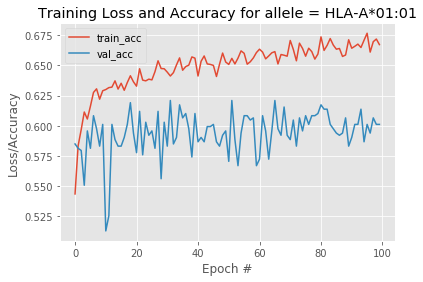

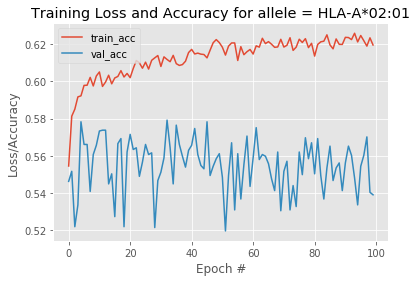

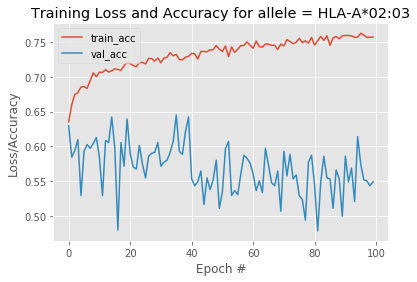

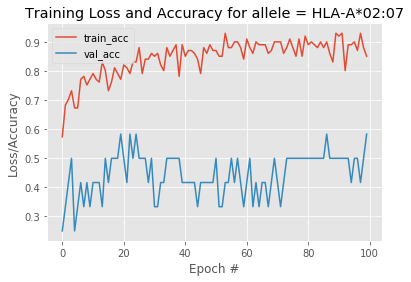

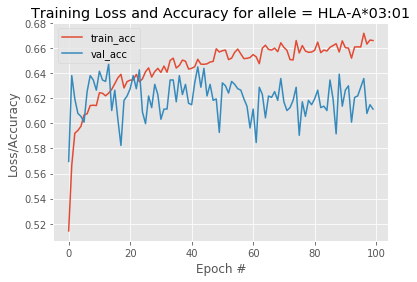

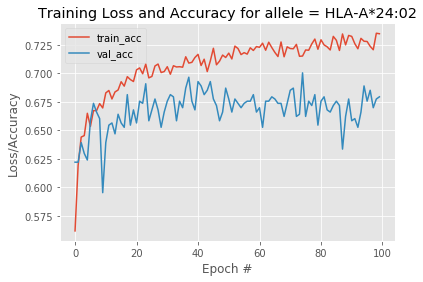

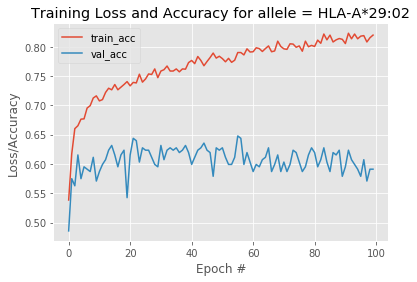

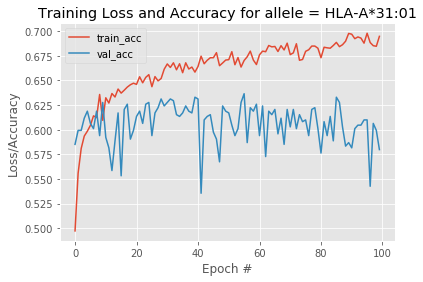

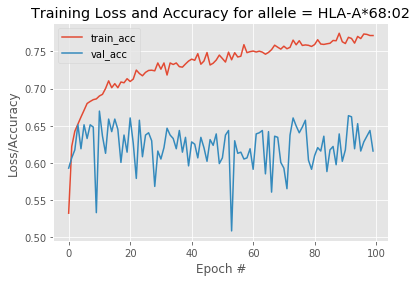

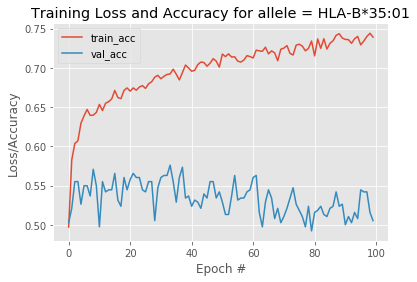

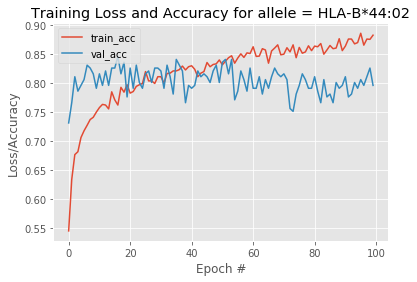

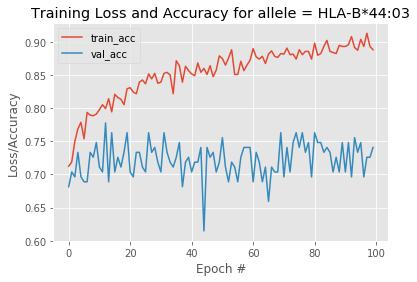

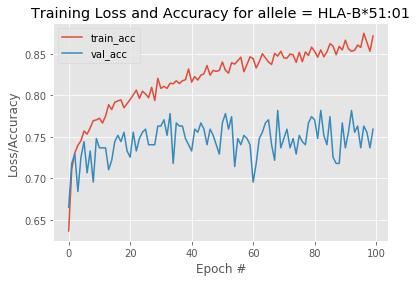

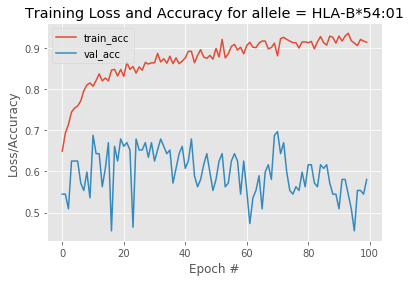

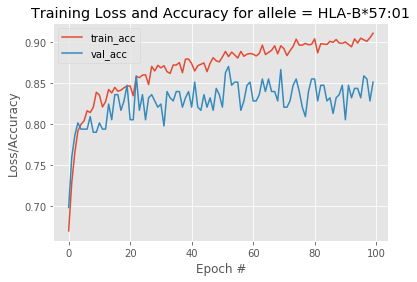

In [32]:
results = pd.DataFrame(columns = ("allele", "val_acc", "pearson_r", "f1_score"))



for x in hla_index:
    
    allele = x
    epochs=100

    history, metrics, results = model_fit_allele(allele=allele, 
                     data = HLA, 
                     test_frac=0.1, 
                     n_class=4, 
                     model=model, 
                     epochs=epochs, 
                     results=results)

In [33]:
results

,allele,val_acc,pearson_r,f1_score
0,HLA-A*01:01,0.611382,0.282063,0.594107
1,HLA-A*02:01,0.618912,0.325391,0.613296
2,HLA-A*02:03,0.715924,0.543764,0.712081
3,HLA-A*02:07,0.769231,0.595586,0.769231
4,HLA-A*03:01,0.636364,0.368099,0.633945
5,HLA-A*24:02,0.638079,0.331196,0.632207
6,HLA-A*29:02,0.658182,0.436878,0.651233
7,HLA-A*31:01,0.605096,0.269746,0.597767
8,HLA-A*68:02,0.717452,0.520754,0.716975
9,HLA-B*35:01,0.627358,0.435016,0.608315


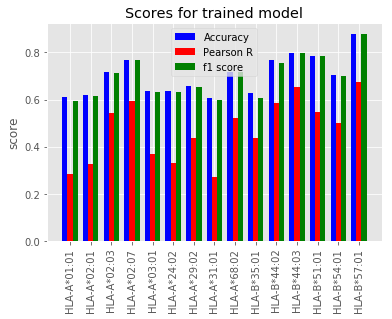

In [34]:
ind = np.arange(len(results["allele"]))  # the x locations for the groups
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, results["val_acc"], width,color='Blue', label='Accuracy')
rects2 = ax.bar(ind, results["pearson_r"], width, color='Red', label='Pearson R')
rects3 = ax.bar(ind + width, results["f1_score"], width, color='Green', label='f1 score')

labels = results["allele"]
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_title('Scores for trained model')
ax.set_xticks(ind)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()

plt.show()